#### Importations

In [43]:
!pip install h5py
from utilities import *
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier



warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/SageMath/local/bin/python3 -m pip install --upgrade pip' command.


#### Chargement des données 

In [44]:
Xa, ya, Xt, yt = load_data() # chargement des training data et des test data

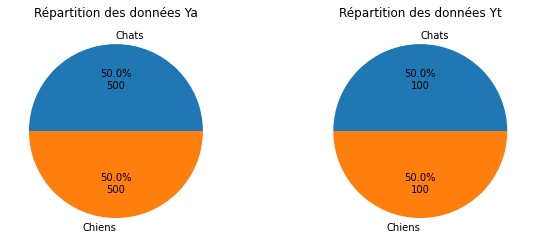

In [45]:
def rep(pct, valeurs):
    '''Retourne un affichage du pourcentage de ma répartition des classes et sa valeur'''
    absolute = int(pct/100.*np.sum(valeurs))
    return f'{pct}%\n{absolute}'
def afficherRepartition(ya,yt):
    '''Affiche un diagramme de la répartition des classes'''
    effectif0=np.unique(ya,return_counts=True)
    effectif1=np.unique(yt,return_counts=True)
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(10)
    axs[0].pie(effectif0[1],autopct=lambda pct: rep(pct, effectif0[1]),labels=["Chats","Chiens"])
    axs[0].set_title('Répartition des données Ya')
    axs[1].pie(effectif1[1],autopct=lambda pct: rep(pct, effectif1[1]),labels=["Chats","Chiens"])
    axs[1].set_title('Répartition des données Yt')
    plt.show()
afficherRepartition(ya,yt)

#### Quelques photos

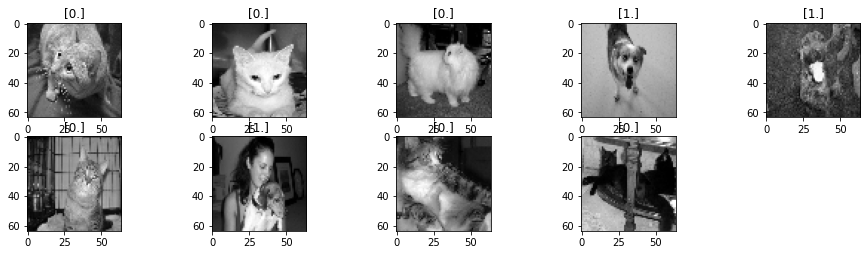

In [46]:
def afficherPhoto(n=9):
    plt.figure(figsize=(16,8))
    for i in range(1,n+1):
        plt.subplot(4,5,i)
        plt.imshow(Xa[i],cmap='gray')
        plt.title(ya[i])
    plt.show()
afficherPhoto()

#### Applatissement des images

In [47]:
# Une fois aplatie, chaque photo est un vecteur de 4096 pixels, 
# donc 4096 variables qui prennent des valeurs entre 0 et 255 (1 pixel = 8 bits)
print("Avant:")
print(Xa.shape)
print(Xt.shape)
Xa=Xa.reshape(Xa.shape[0],Xa.shape[1]*Xa.shape[2]).T
Xt=Xt.reshape(Xt.shape[0],Xt.shape[1]*Xt.shape[2]).T
ya=ya.T
yt=yt.T
print("Après:")
print(Xa.shape)
print(Xt.shape)

Avant:
(1000, 64, 64)
(200, 64, 64)
Après:
(4096, 1000)
(4096, 200)


#### Normalisation des données

In [48]:
Xa=(Xa/255)
Xt=(Xt/255)


def load_reshape():
    '''Load les données ,reshape et normalise'''
    Xa, ya, Xt, yt = load_data()
    Xa=Xa.reshape(Xa.shape[0],Xa.shape[1]*Xa.shape[2]).T
    Xt=Xt.reshape(Xt.shape[0],Xt.shape[1]*Xt.shape[2]).T
    Xa=Xa/255 
    Xt=Xt/255
    ya=ya.T
    yt=yt.T
    return Xa,ya,Xt,yt
Xa,ya,Xt,yt=load_reshape()
print(Xa.shape)


(4096, 1000)


# Perceptron : 

##### Hyperparamètres : 

## Une couche : S neurones

#### Formes de nos données : (n variables  en entrée , m échantillons , s en sortie ( neurones) )

$$\begin{alignat}{2} X = & \underbrace{\begin{bmatrix}
x_{11} & x_{12}&...& x_{1m}\\
... &  ...&   ...&   ...&\\
x_{n1} & x_{n2}&...& x_{nm}
\end{bmatrix}}_{(n,m)}\\
Y = & \underbrace{\begin{bmatrix}
y_{1} & y_{2} &... &y_{m}\end{bmatrix}}_{(1,m)}\\
W = & \underbrace{\begin{bmatrix}w_{11} & w_{12} &... &w_{1n}\\
... & ... &... &...\\
w_{s1} & w_{s2} &... &w_{sn}\\
\end{bmatrix}}_{(s,n)}
\end{alignat}$$

##### Vectorisation du modèle

$$
\forall j \in \{1,...,s\} : neurones\\
\forall k \in \{1,...,m\} : échantillons
$$ 

$$\begin{alignat}{2} z_{jk} =& \sum_{i=1}^n w_{ji}.x_{ik} + b_j\\
a_{jk}=&\frac{1}{1+e^{-z_{jk}}}\\
\newline
\underbrace{Z}_{(s,m)} = & \begin{bmatrix}
\sum_{i=1}^n w_{1i}.x_{i1} + b_1 &, &\sum_{i=1}^n w_{1i}.x_{i2} + b_1 &, &... &, &\sum_{i=1}^n w_{1i}.x_{im} + b_1\\
... &,  &... &, &... &,  & ...\\
\sum_{i=1}^n w_{si}.x_{i1} + b_s &, &\sum_{i=1}^n w_{si}.x_{i2} + b_s &, &... &, &\sum_{i=1}^n w_{si}.x_{im} + b_s\\
\end{bmatrix}\\
\newline
\underbrace{Z}_{(s,m)}=&\underbrace{\begin{bmatrix}w_{11} & w_{12} &... &w_{1n}\\
... & ... &... &...\\
w_{s1} & w_{s2} &... &w_{sn}\\
\end{bmatrix}}_{(s,n)}.\underbrace{\begin{bmatrix}
x_{11} & x_{12}&...& x_{1m}\\
... &  ...&   ...&   ...&\\
x_{n1} & x_{n2}&...& x_{nm}
\end{bmatrix}}_{(n,m)} + \underbrace{\begin{bmatrix}
b_1 & b_1 & ... & b_1\\
... & ... & ... & ...\\
b_s & b_s & ... & b_s\end{bmatrix}}_{(s,m)}\\
\underbrace{Z}_{(s,m)}= & W.X+B \\
\underbrace{A}_{(s,m)}= &\frac{1}{1+e^{-Z}}\\
\end{alignat}$$

On obtient les activations ou les lignes correspondent aux neurones et colonne aux échantillons.
Dans la pratique, notre fonction de coût n'utilise que l'activation d'un neurone par échantillon donc pour un modèle à une seule couche, le nombre de neurone est forcément réduit à un.

Remarque : Avec numpy , on peut additioner un tableau avec un entier donc b peut être réduit à une seul élément par neurone c'est a dire une shape de (s,1)

In [49]:
def initParam(n_input,n_output=1): #n_output = 1 pour un modèle à une seule couche
    W=np.random.randn(n_output,n_input)
    b=np.random.randn(n_output,1)
    return (W,b)
W,b=initParam(Xt.shape[0])
print(W.shape)
print(b)

(1, 4096)
[[-0.09003327]]


In [50]:
def perceptron(X,W,b):
    Z=W.dot(X)+b
    A=1/ (1+np.exp(-Z))
    return A
A=perceptron(Xt,W,b)
print(A.shape)

(1, 200)


##### Nos fonctions coûts :

Elles sont définies sur "une" activation de m échantillons donc la derniere couche de notre modèle.


$$\begin{alignat}{2} L_{MSE}=& \frac{1}{m}.\sum_{k=1}^{m} (y_k-a_k)^2\\
L_{log\_loss}=& -\frac{1}{m}.\sum_{k=1}^{m} y_{k}.ln(a_{k})+(1-y_k).ln(1-a_k)
\end{alignat}$$

In [51]:
def MSE_cost(A,y):
    return 1/y.shape[1]*np.sum((y-A)**2)

def log_loss(A,y,eps=10**(-15)):
    return - 1/y.shape[1]* np.sum(y *np.log(A+eps) + (1 - y) * np.log(1-A+eps))
c1=MSE_cost(A,yt)
print(c1)
c2=log_loss(A,yt)
print(c2)

0.5032857220148254
8.979024463966844


## Gradients de log loss ( n variables , m échantillons , s sorties)

$$
\forall j \in \{1,...,s\}\\
\forall i \in \{1,...,m\} 
$$ 

##### Calcul des gradients

$$
\begin{alignat}{5}
&\frac{\partial L}{\partial a_{ji}} = -\frac{1}{m}.\sum_{k=1}^m \frac{y_k-a_{jk}}{a_{jk}(1-a_{jk})}\\
&\frac{\partial a_{ji}}{\partial z} = a_{ji}(1-a_{ji})\\
&\frac{\partial z}{\partial w_{ji}} = x_{i}\\
&\frac{\partial z}{\partial b} = 1\\
\newline\newline
&\frac{\partial L}{\partial w_{ji}} = \frac{\partial L}{\partial a_{ji}} . \frac{\partial a_{ji}}{\partial z} .\frac{\partial z}{\partial w_{ji}}\\
&\frac{\partial L}{\partial w_{ji}} =-\frac{1}{m}.\sum_{k=1}^m (y_k-a_{jk}).x_{ik} = \frac{1}{m}.\sum_{k=1}^m (a_{jk}-y_k).x_{ik}\\
&\frac{\partial L}{\partial b_j} = \frac{1}{m}.\sum_{k=1}^m (a_{jk}-y_k)
\end{alignat}
$$

#### Vectorisation des gradients

$$\begin{alignat}{5}
    \underbrace{\frac{\partial L}{\partial W}}_{(s,n)}&= \frac{1}{m}.\begin{bmatrix}
\frac{1}{m}.\sum_{k=1}^m (a_{1k}-y_k).x_{1k}&, &...&,  &\frac{1}{m}.\sum_{k=1}^m (a_{1k}-y_k).x_{nk}\\
... &,  &...&,   &...\\
\frac{1}{m}.\sum_{k=1}^m (a_{sk}-y_k).x_{1k}&, &...&,  &\frac{1}{m}.\sum_{k=1}^m (a_{sk}-y_k).x_{nk}\\
\end{bmatrix} \quad ligne = neurone \quad et \quad colonne = caractéristiques(input)\\
\newline
 \underbrace{\frac{\partial L}{\partial W}}_{(s,n)}&= \frac{1}{m}.\underbrace{\Bigg(\begin{bmatrix}
a_{11} & a_{12} & ... & a_{1m}\\
... & ... & ... &...\\
a_{s1} & a_{s2} & ... & a_{sm}\end{bmatrix}-\begin{bmatrix}
y_1 & y_2 & ... & y_m\\
... & ... & ... & ...\\
y_1 & y_2 & ... & y_m
\end{bmatrix}\Bigg)}_{(s,m)}.\underbrace{\begin{bmatrix}
x_{11} & x_{21}&...& x_{n1}\\
... &  ...&   ...&   ...&\\
x_{1m} & x_{2m}&...& x_{nm}
\end{bmatrix}}_{(m,n) \rightarrow X^T}\\
\underbrace{\frac{\partial L}{\partial W}}_{(s,n)}& = \frac{1}{m}.(A-y).X^T\\
\underbrace{\frac{\partial L}{\partial B}}_{(s,1)}& = \frac{1}{m}.\sum_{k=1}^m (a_{jk}-y_k)\\
\end{alignat}$$

Même remarque : Avec numpy , on peut soustraire la même ligne Y a tout un tableau donc Y peut garder sa shape (1,m)



In [52]:
def MSE_gradient(A,X,y):
    m=y.shape[1]
    B=(A-y)*A*(1-A)
    dW=2/m *np.dot(B,X.T)
    db=2/m * np.sum(B,axis=1,keepdims=True) #pour rester a une dimension ( s,1 )
    return (dW,db)

def log_gradient(A,X,y,eps=10**(-15)):
    B=A-y
    m=y.shape[1]
    dW= 1 / m * np.dot(B,X.T)
    db=1 / m * np.sum(B,axis=1,keepdims=True) #pour rester a une dimension ( s,1 )
    return (dW,db)

dW1,db1=MSE_gradient(A,Xt,yt)
dW2,db2=log_gradient(A,Xt,yt)
print(dW1.shape,dW2.shape)
print(db1)
print(db2)

(1, 4096) (1, 4096)
[[0.0014925]]
[[0.41933454]]


In [53]:
def mAj(dW,db,W,b,alpha):
    W=W-dW*alpha
    b=b-db*alpha
    return (W,b)
W,b=mAj(dW2,db2,W,b,0.01)
print(W.shape)
print(b)

(1, 4096)
[[-0.09422661]]


In [54]:
def learnRN(X,y,gradient=log_gradient,alpha=0.1, iter=100): 
    W,b=initParam(X.shape[0])
    k=0
    while k<iter:
        A=perceptron(X,W,b)
        dW,db=gradient(A,X,y)
        W,b=mAj(dW,db,W,b,alpha)
        k+=1
    return W,b

In [55]:
def predict(X,W,b):
    A=perceptron(X,W,b)
    return np.where(A>0.5,1.,0.)   # si A>0.5 1 sinon 0

In [56]:
def initParam_opti(X,y,cout,nb_iter=100):
    '''test nb_iter (W,b) aléatoires et 
    renvoie celui qui dont le cout du modèle est minimal'''
    maxi=200
    for i in range(nb_iter):
        W=np.random.randn(1,X.shape[0])
        b=np.random.randn(1)
        c=cout(perceptron(X,W,b),y)
        if c<maxi:
            Wm,bm=W,b
    return Wm,bm

#### Affichons notre apprentissage

In [57]:
def learnRN_affichage(Xa,ya,Xt,yt,gradient,cost,alpha=0.1, iter=1000): 
    '''Fonction d'apprentissage avec mémorisation de la progression'''
    W,b = initParam_opti(Xa,ya,cost)
    k=0
    couts_A,couts_t,scores_A,scores_t=[],[],[],[]
    while k<iter:
        A=perceptron(Xa,W,b)
        dW,db=gradient(A,Xa,ya)
        W,b=mAj(dW,db,W,b,alpha)
        if k%10==0: # pour diminuer le nombre de calculs
            At=perceptron(Xt,W,b)
            couts_A.append(cost(A,ya))
            couts_t.append(cost(At,yt))
            scores_A.append(accuracy_score(ya[0],predict(Xa,W,b)[0]))
            scores_t.append(accuracy_score(yt[0],predict(Xt,W,b)[0]))
        k+=1
    return W,b,couts_A,couts_t,scores_A,scores_t

def afficherApprentissage(couts_A,couts_t,scores_A,scores_t,bid=10):
    X= [ x*bid for x in range(len(couts_A))] #nombre d'itérations
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(14)
    axs[0].plot(X,couts_A,label='loss apprentissage')
    axs[0].plot(X,couts_t,label='loss test')
    axs[0].set_title('Loss curve')
    axs[0].set_xlabel('itérations')
    axs[0].set_ylabel('cost')
    axs[0].legend()
    axs[1].plot(X,scores_A,label='score apprentissage')
    axs[1].plot(X,scores_t,label='score test')
    axs[1].set_title(f'Learning curve')
    axs[1].set_xlabel('itérations')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

#### MSE

In [58]:
Xa,ya,Xt,yt=load_reshape()
W1,b1,cA1,ct1,sA1,st1= learnRN_affichage(Xa,ya,Xt,yt,MSE_gradient,MSE_cost,0.2,1000)


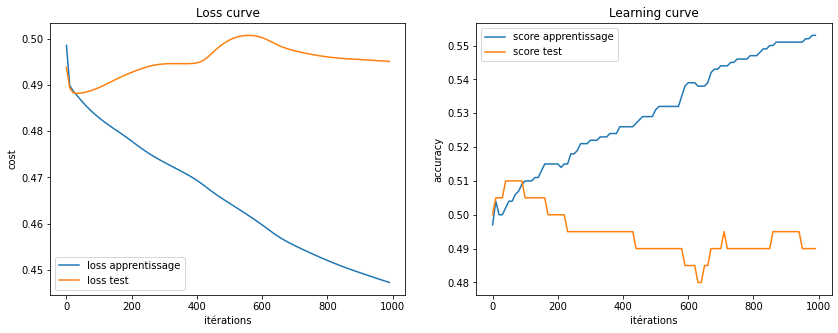

In [59]:
afficherApprentissage(cA1,ct1,sA1,st1)

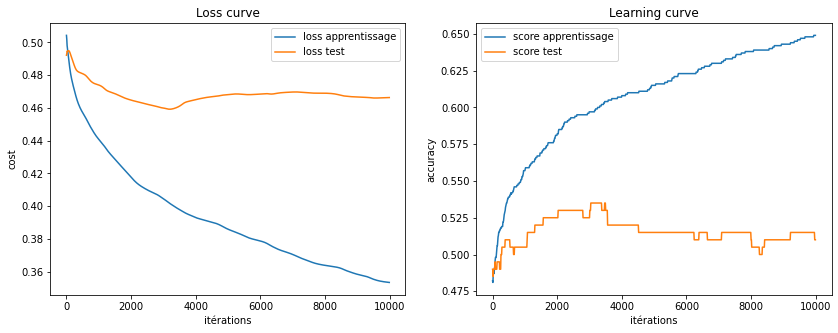

In [60]:
cA_test,ct_test,sA_test,st_test=[0.5042951017918629, 0.5018370899880018, 0.49804991609845184, 0.496330407839305, 0.49459709521614276, 0.4928092771503409, 0.49104653331022574, 0.48935864911712323, 0.48775687015028085, 0.486223318273509, 0.484738189823138, 0.48330788711385925, 0.48196256983671654, 0.48072730322484225, 0.4796022630878422, 0.4785700709738484, 0.47760944798418564, 0.4767014521561252, 0.47583125736766363, 0.47498904933811786, 0.47416978884092054, 0.47337067751934503, 0.4725881208490783, 0.47181729252327514, 0.47105391092232723, 0.4702957010882092, 0.469542582140706, 0.4687962929478684, 0.46806017482336326, 0.4673389601513084, 0.4666379653388176, 0.4659616680579052, 0.4653125627140317, 0.4646910638390484, 0.46409622563802283, 0.46352656047186064, 0.4629805414966198, 0.46245677777959565, 0.46195400447025964, 0.46147101472902013, 0.46100660205955124, 0.46055953512032705, 0.4601285612371721, 0.4597124255528759, 0.4593098933292558, 0.45891976738719775, 0.4585408971929783, 0.45817217908874014, 0.45781254852232467, 0.45746096535697944, 0.45711639297336615, 0.4567777712871744, 0.45644398321068363, 0.456113813648038, 0.45578590010532966, 0.4554586750710795, 0.45513030398848203, 0.45479863201394505, 0.4544611731913998, 0.45411521287051665, 0.45375814222218597, 0.45338815137760186, 0.4530052437739424, 0.45261209437477257, 0.45221387716489997, 0.45181664917449427, 0.4514252124699806, 0.4510419538187872, 0.45066711287115274, 0.4502997387596798, 0.4499385241718365, 0.44958224770221356, 0.44922991963753484, 0.44888078906248124, 0.4485343115089369, 0.4481901173699886, 0.4478479899838139, 0.4475078510426588, 0.44716974890094263, 0.44683384610137095, 0.4465004036304969, 0.4461697607682407, 0.44584231116794826, 0.44551847776667863, 0.4451986902788157, 0.44488336823876307, 0.44457290970961516, 0.4442676823527052, 0.44396801192851565, 0.4436741650055433, 0.44338632700194075, 0.44310458098774325, 0.44282889412573895, 0.44255911637562645, 0.44229499171771064, 0.4420361782611911, 0.4417822718932488, 0.4415328286608616, 0.4412873828438853, 0.4410454595584357, 0.44080658207535567, 0.4405702747090633, 0.4403360622771346, 0.44010346697653097, 0.4398720032580824, 0.43964117103505057, 0.43941044742050095, 0.43917927722723354, 0.4389470627776693, 0.4387131542956939, 0.43847684347243515, 0.43823736490450704, 0.4379939130253404, 0.43774568530900376, 0.4374919638701057, 0.4372322425925315, 0.4369663892079639, 0.4366947990358516, 0.43641846395355766, 0.43613888366201264, 0.4358578158209316, 0.4355769624728648, 0.4352977306383376, 0.4350211426265491, 0.4347478725811614, 0.434478336865071, 0.43421278002548774, 0.43395133390574125, 0.4336940515946427, 0.43344092496192094, 0.4331918928846091, 0.4329468444339198, 0.43270561984883155, 0.4324680116095023, 0.4322337673631761, 0.43200259551561204, 0.43177417325340944, 0.4315481560131127, 0.4313241871655499, 0.43110190688166294, 0.43088095958666633, 0.43066099988279155, 0.43044169718920394, 0.4302227395590395, 0.430003837198441, 0.42978472617026164, 0.42956517265618255, 0.4293449780005756, 0.4291239845734882, 0.4289020822615862, 0.42867921511861107, 0.42845538739267963, 0.42823066784075614, 0.42800519102303997, 0.427779154252348, 0.42755280916521704, 0.42732644754124544, 0.4271003819760816, 0.4268749231183482, 0.4266503560995728, 0.4264269191935762, 0.4262047874507351, 0.4259840631233257, 0.4257647734248543, 0.42554687494046234, 0.42533026314271805, 0.42511478509872636, 0.4249002535276235, 0.42468646072184446, 0.4244731913044132, 0.4242602332255436, 0.4240473867358987, 0.4238344712949023, 0.42362133049644013, 0.4234078351493706, 0.423193884664578, 0.4229794068963956, 0.42276435658079353, 0.4225487125183194, 0.422332473675935, 0.42211565443421717, 0.42189827928350315, 0.4216803773630228, 0.42146197731885976, 0.42124310300153456, 0.4210237705061566, 0.42080398696312193, 0.42058375131828485, 0.4203630571182634, 0.42014189707000754, 0.41992026890852036, 0.4196981819157907, 0.41947566331736824, 0.41925276376642245, 0.419029561226959, 0.41880616279099386, 0.41858270428604144, 0.4183593478952223, 0.418136278344142, 0.4179136984243135, 0.41769182466443333, 0.41747088381625885, 0.41725111052895997, 0.4170327462174515, 0.4168160387700202, 0.416601242462864, 0.41638861730935744, 0.41617842710461755, 0.41597093564212356, 0.4157664009557782, 0.41556506790928793, 0.41536715990213935, 0.4151728707576443, 0.41498235790543164, 0.41479573774907585, 0.4146130836921607, 0.41443442681685905, 0.4142597588042884, 0.4140890364424172, 0.41392218700305533, 0.41375911384697583, 0.4135997017730744, 0.4134438218045412, 0.41329133526197237, 0.4131420970913096, 0.41299595849099263, 0.4128527689244535, 0.4127123776210424, 0.412574634670087, 0.4124393918065073, 0.4123065029772266, 0.4121758247685328, 0.4120472167669539, 0.4119205419204601, 0.4117956669624387, 0.4116724629569011, 0.41155080601829036, 0.4114305782511557, 0.41131166894162635, 0.4111939760117038, 0.41107740771685425, 0.41096188452618343, 0.4108473410735933, 0.4107337280119379, 0.4106210135486488, 0.4105091844032014, 0.41039824591953067, 0.4102882211045569, 0.41017914845536735, 0.4100710785780276, 0.4099640697704266, 0.40985818290617115, 0.40975347607710055, 0.40964999949651637, 0.4095477911207939, 0.40944687332502383, 0.40934725080025297, 0.4092489096659758, 0.4091518176473677, 0.40905592507377847, 0.40896116641786934, 0.408867462104581, 0.4087747203598841, 0.40868283892407276, 0.408591706509529, 0.40850120392955275, 0.40841120485875126, 0.4083215762056956, 0.4082321780860807, 0.40814286338129535, 0.40805347685495974, 0.4079638537803464, 0.40787381800640854, 0.4077831793620934, 0.40769173027311895, 0.40759924145424464, 0.40750545656832626, 0.4074100858624763, 0.4073127991016935, 0.40721321880569145, 0.40711091616309325, 0.40700541447252286, 0.4068962088549067, 0.4067828156297225, 0.4066648664181729, 0.40654225121351206, 0.40641527854679665, 0.40628476392346724, 0.4061519348461576, 0.40601813101002004, 0.4058844463369757, 0.4057515171352178, 0.40561952626827985, 0.4054883359976886, 0.40535763424999244, 0.40522703867139315, 0.40509615574922897, 0.40496461052703375, 0.4048320610934368, 0.4046982064002931, 0.4045627916963223, 0.4044256134733469, 0.40428652463810283, 0.40414544006365377, 0.4040023423927246, 0.40385728774319996, 0.4037104106547388, 0.4035619271506156, 0.4034121342518934, 0.4032614039368595, 0.40311016976785824, 0.40295890549464225, 0.40280809680407115, 0.40265820944165265, 0.40250965831233776, 0.4023627822011774, 0.40221782738839923, 0.4020749412750794, 0.4019341750617849, 0.4017954931914325, 0.40165878686974194, 0.4015238893082201, 0.4013905910325238, 0.4012586543444693, 0.4011278266302372, 0.40099785260182086, 0.40086848574540396, 0.40073949925640145, 0.4006106965945483, 0.40048192151975526, 0.40035306710671525, 0.4002240828491335, 0.4000949786623871, 0.39996582452277385, 0.39983674478298914, 0.3997079069353364, 0.3995795056535889, 0.3994517440458453, 0.39932481480857324, 0.3991988840708459, 0.3990740800774252, 0.39895048768555824, 0.39882814833448965, 0.3987070640829353, 0.3985872037440981, 0.39846850912870224, 0.3983508998288505, 0.3982342756616447, 0.3981185166610338, 0.3980034812169424, 0.39788900352674267, 0.3977748919210501, 0.3976609298795714, 0.3975468817040779, 0.397432504852871, 0.39731757070734386, 0.3972018946537912, 0.3970853742473375, 0.39696803043892315, 0.39685004185182493, 0.39673175817604966, 0.396613679903272, 0.39649640091416266, 0.39638052562169224, 0.3962665847820447, 0.396154974730375, 0.3960459330425019, 0.39593954797895264, 0.39583578897512317, 0.39573454394578583, 0.3956356532730158, 0.39553893566262116, 0.39544420501091815, 0.3953512795056833, 0.39525998489188874, 0.3951701538083598, 0.3950816227911081, 0.3949942281725405, 0.39490780177886897, 0.3948221670756249, 0.39473713624711726, 0.3946525086281648, 0.3945680709393728, 0.3944835999045474, 0.3943988680227716, 0.3943136534591812, 0.3942277550695925, 0.39414101325244405, 0.3940533363114811, 0.39396473003150223, 0.3938753252625695, 0.3937853952889627, 0.3936953534609105, 0.39360572424967133, 0.3935170884393464, 0.3934300131638045, 0.39334498452423206, 0.39326235989257735, 0.393182348866175, 0.39310502122402957, 0.3930303328377373, 0.39295815865870676, 0.39288832429737225, 0.39282063158670805, 0.39275487683110777, 0.3926908624313531, 0.39262840338490457, 0.39256733023215784, 0.3925074897545024, 0.39244874438036764, 0.3923909709408657, 0.39233405917589315, 0.3922779102240251, 0.3922224352204721, 0.3921675540601083, 0.3921131943431343, 0.3920592904990784, 0.39200578307355183, 0.3919526181569865, 0.3918997469326781, 0.39184712532122246, 0.3917947136989308, 0.39174247666862677, 0.3916903828621728, 0.39163840475518197, 0.39158651847573483, 0.3915347035906679, 0.39148294285527846, 0.39143122191514856, 0.39137952895225214, 0.39132785427146577, 0.3912761898278589, 0.39122452869942914, 0.3911728645139186, 0.39112119084167957, 0.39106950056893064, 0.39101778526697045, 0.3909660345728993, 0.39091423559621363, 0.3908623723634876, 0.39081042531053545, 0.3907583708283694, 0.39070618086628467, 0.3906538225929262, 0.3906012581144974, 0.39054844424859786, 0.3904953323526403, 0.39044186820743954, 0.3903879919593072, 0.39033363812766564, 0.3902787356895118, 0.3902232082565537, 0.3901669743648295, 0.39010994789912773, 0.39005203867425803, 0.3899931531905386, 0.38993319556995754, 0.3898720686607031, 0.3898096752703437, 0.3897459194529984, 0.3896807077376588, 0.38961395015206607, 0.3895455608826419, 0.38947545843261955, 0.38940356521344566, 0.3893298066359634, 0.38925410994695936, 0.38917640324540664, 0.3890966152425165, 0.3890146763085344, 0.3889305210863887, 0.38884409240630174, 0.38875534548556784, 0.3886642507199754, 0.3885707932614275, 0.38847496860927005, 0.38837677593405046, 0.3882762143697324, 0.38817329055884275, 0.38806804591428123, 0.3879606068143335, 0.3878512490122874, 0.3877404514710455, 0.3876289037807036, 0.38751743924344645, 0.3874068989910415, 0.3872979744330576, 0.38719109248658923, 0.38708638400266193, 0.3869837314559983, 0.3868828616111529, 0.3867834457448145, 0.38668518322877915, 0.3865878584752983, 0.3864913695813202, 0.38639573055246684, 0.3863010511357601, 0.3862075009147832, 0.3861152668667463, 0.3860245142646223, 0.3859353585807705, 0.3858478517007942, 0.3857619813159756, 0.385677679571701, 0.38559483638869413, 0.38551331372930403, 0.3854329585002914, 0.3853536130671146, 0.3852751232143884, 0.3851973438269985, 0.38512014271065037, 0.38504340295174666, 0.3849670241308421, 0.3848909226086809, 0.3848150310273277, 0.3847392971219981, 0.3846636819225356, 0.38458815743175506, 0.3845127038919691, 0.38443730677991156, 0.3843619536930604, 0.38428663129856305, 0.38421132250536233, 0.3841360039916315, 0.3840606441786379, 0.38398520169674216, 0.3839096243478165, 0.3838338485376655, 0.3837577991359481, 0.38368138972060034, 0.3836045231775305, 0.383527092651711, 0.3834489828795379, 0.3833700719710304, 0.3832902337502604, 0.3832093407982616, 0.38312726836702343, 0.3830438993346355, 0.382959130334037, 0.38287287909078305, 0.38278509282816026, 0.3826957573290227, 0.38260490589498986, 0.3825126270693742, 0.38241906969853334, 0.3823244438483615, 0.3822290164135244, 0.38213310101267167, 0.38203704283945683, 0.3819412002403691, 0.38184592553598296, 0.3817515477089841, 0.3816583590172562, 0.3815666065885717, 0.3814764889865411, 0.38138815692695094, 0.38130171691912473, 0.38121723657966505, 0.38113475058312507, 0.3810542665271417, 0.3809757702893329, 0.3808992306850889, 0.3808246033875819, 0.38075183415605013, 0.3806808614558171, 0.3806116185624434, 0.3805440352368347, 0.3804780390468234, 0.38041355639845914, 0.3803505133291083, 0.3802888361051359, 0.3802284516593635, 0.3801692878973779, 0.38011127389675986, 0.3800543400191522, 0.37999841795158446, 0.3799434406904753, 0.3798893424791786, 0.37983605870772297, 0.3797835257815123, 0.3797316809641304, 0.37968046219801604, 0.3796298079056002, 0.3795796567724944, 0.3795299475134641, 0.3794806186211849, 0.3794316080971357, 0.379382853163427, 0.3793342899538553, 0.37928585318204205, 0.37923747578411954, 0.3791890885330996, 0.37914061962181245, 0.3790919942111583, 0.3790431339404348, 0.3789939563967702, 0.37894437454131524, 0.37889429609101966, 0.3788436228567783, 0.3787922500418537, 0.3787400655092529, 0.3786869490338514, 0.3786327715654137, 0.37857739454342115, 0.378520669325172, 0.3784624368164416, 0.37840252743035635, 0.3783407615453244, 0.3782769506848867, 0.3782108996947086, 0.3781424102304248, 0.3780712858690944, 0.37799733907720146, 0.3779204000590489, 0.3778403271245429, 0.377757017645804, 0.37767041799826806, 0.3775805303219353, 0.37748741384083767, 0.37739117920108944, 0.37729197595789116, 0.37718997563030326, 0.37708535486594225, 0.37697828431672836, 0.3768689282765015, 0.37675745798674, 0.37664407812976064, 0.3765290617648059, 0.3764127843167843, 0.3762957435030723, 0.37617855185801324, 0.3760618945443665, 0.3759464573672678, 0.37583284309320075, 0.3757215001767792, 0.3756126824185985, 0.3755064446577573, 0.3754026669399538, 0.3753010938928427, 0.3752013775356476, 0.3751031168753101, 0.3750058927556981, 0.3749092996615369, 0.3748129771802312, 0.37471664283311534, 0.37462012531576194, 0.37452339335828094, 0.37442657171721444, 0.3743299345919915, 0.3742338705546103, 0.3741388222708035, 0.374045215077489, 0.3739533942687819, 0.373863587440189, 0.37377589752366863, 0.37369032092408727, 0.37360677910647, 0.3735251521340224, 0.3734453064916222, 0.3733671139628992, 0.37329046158966284, 0.37321525447161275, 0.3731414137258487, 0.37306887180971526, 0.3729975669796434, 0.372927438126035, 0.37285842070685454, 0.37279044406653006, 0.3727234301068936, 0.3726572930819692, 0.37259194020486885, 0.37252727275470476, 0.3724631874213948, 0.37239957769738763, 0.37233633519686554, 0.37227335084309265, 0.37221051590882215, 0.3721477229232672, 0.3720848664746193, 0.3720218439426658, 0.3719585561946069, 0.3718949082709576, 0.3718308100790047, 0.3717661770997271, 0.3717009311011207, 0.37163500083715817, 0.3715683226978939, 0.3715008412634467, 0.371432509703914, 0.37136328996002727, 0.3712931526369123, 0.37122207654684575, 0.3711500478472287, 0.37107705873742197, 0.37100310570245376, 0.3709281873224359, 0.37085230170347855, 0.3707754436292448, 0.37069760158346476, 0.3706187548556818, 0.3705388710196076, 0.3704579041705682, 0.3703757944283611, 0.37029246934940807, 0.37020784802455453, 0.37012184871004616, 0.37003440074142224, 0.3699454610458069, 0.3698550346003547, 0.36976319656949375, 0.3696701117803494, 0.3695760454067533, 0.36948135853358793, 0.36938648493780185, 0.3692918909898346, 0.3691980269536448, 0.3691052816644474, 0.36901395120101804, 0.36892422651464507, 0.3688361983834784, 0.3687498737880526, 0.3686651969422255, 0.3685820697837745, 0.3685003690844825, 0.36841995931417193, 0.368340701581409, 0.368262459469974, 0.36818510265438453, 0.3681085090402697, 0.36803256598029466, 0.3679571709332062, 0.3678822317864706, 0.3678076669543154, 0.3677334052877251, 0.36765938578526375, 0.367585557069138, 0.36751187658675777, 0.3674383095117161, 0.3673648273465302, 0.36729140626825907, 0.36721802530150316, 0.3671446644449703, 0.36707130291202167, 0.3669979176685722, 0.3669244824620423, 0.36685096753356267, 0.3667773401937127, 0.36670356641942925, 0.3666296135918746, 0.3665554544317233, 0.3664810720839149, 0.3664064661416315, 0.3663316591703838, 0.36625670301155233, 0.36618168386327127, 0.3661067249546199, 0.36603198567713296, 0.36595765642586253, 0.36588394914285777, 0.3658110845007753, 0.3657392775177182, 0.36566872382995225, 0.36559958867990866, 0.3655319999664827, 0.36546604573440644, 0.36540177559376136, 0.3653392050011486, 0.36527832116371256, 0.3652190894623401, 0.36516145958575796, 0.365105370892092, 0.36505075678791454, 0.36499754810634005, 0.36494567557818075, 0.3648950715417036, 0.3648456710479875, 0.3647974125077326, 0.3647502380039038, 0.36470409337036985, 0.3646589281138432, 0.3646146952367565, 0.3645713510027506, 0.36452885467401147, 0.3644871682403005, 0.3644462561526108, 0.36440608506941485, 0.3643666236199721, 0.36432784218677217, 0.3642897127075926, 0.36425220849662054, 0.3642153040834677, 0.36417897506855335, 0.36414319799317196, 0.3641079502225138, 0.36407320983994224, 0.3640389555509072, 0.3640051665949717, 0.3639718226645343, 0.36393890382893607, 0.36390639046273254, 0.36387426317699945, 0.36384250275260793, 0.3638110900744569, 0.3637800060656904, 0.3637492316209426, 0.3637187475376577, 0.36368853444451077, 0.3636585727259205, 0.363628842441584, 0.3635993232398847, 0.3635699942639197, 0.3635408340487596, 0.36351182040839636, 0.3634829303106436, 0.36345413973802504, 0.3634254235324264, 0.3633967552209818, 0.36336810682031845, 0.3633394486158993, 0.36331074891277426, 0.36328197375359866, 0.3632530865993037, 0.3632240479673557, 0.3631948150221507, 0.3631653411118502, 0.3631355752459872, 0.36310546150865186, 0.3630749384032671, 0.36304393812730557, 0.3630123857793352, 0.36298019850732616, 0.3629472846172787, 0.3629135426763385, 0.36287886066634323, 0.3628431152740266, 0.36280617144444466, 0.362767882374942, 0.36272809018569013, 0.36268662756147935, 0.36264332070070987, 0.3625979939005531, 0.36255047600556967, 0.36250060869342515, 0.3624482561174748, 0.36239331477371856, 0.36233572171929435, 0.36227545870587985, 0.362212549796808, 0.362147050977389, 0.3620790322244994, 0.3620085550715878, 0.36193565109254106, 0.3618603081608382, 0.36178247150910886, 0.36170206564109314, 0.36161904090272645, 0.3615334437382509, 0.3614455000735961, 0.3613556863936931, 0.36126474972225997, 0.3611736421675994, 0.3610833709966842, 0.36099481658153176, 0.3609085950156424, 0.3608250134892662, 0.36074411073486495, 0.36066573929755635, 0.3605896476473484, 0.36051554073870057, 0.3604431162481702, 0.36037208257625225, 0.3603021660557799, 0.36023311301768807, 0.3601646901604034, 0.36009668503429165, 0.3600289074606472, 0.3599611921481849, 0.35989340243646795, 0.3598254348434987, 0.35975722385623826, 0.3596887461737383, 0.3596200234402876, 0.35955112247236637, 0.35948215217232066, 0.35941325677226327, 0.3593446057113823, 0.35927638116141747, 0.3592087647596878, 0.35914192529759387, 0.35907600887762137, 0.35901113248232264, 0.35894738119332154, 0.3588848086703569, 0.3588234400923123, 0.3587632766123128, 0.3587043004410192, 0.35864647986056264, 0.3585897737026433, 0.35853413503935755, 0.35847951400442046, 0.35842585977818214, 0.35837312183784464, 0.3583212506055246, 0.35827019763264734, 0.3582199154491909, 0.35817035718768764, 0.35812147606960876, 0.3580732248190659, 0.35802555504764444, 0.3579784166357644, 0.3579317571206949, 0.3578855210892596, 0.3578396495640695, 0.35779407936531094, 0.3577487424251212, 0.35770356502778106, 0.35765846694579795, 0.35761336043898745, 0.3575681490806079, 0.3575227263714504, 0.3574769740998934, 0.3574307604043249, 0.35738393749608954, 0.3573363390101766, 0.35728777697427155, 0.3572380384368649, 0.35718688189267184, 0.3571340338227099, 0.35707918597967264, 0.35702199457118367, 0.3569620833114906, 0.3568990534821428, 0.3568325055623187, 0.35676207812706345, 0.3566875091752202, 0.35660872029677354, 0.3565259122844235, 0.3564396424022652, 0.35635083822447533, 0.35626071021628786, 0.3561705675729522, 0.35608159881638735, 0.3559947024509888, 0.3559104197659824, 0.3558289630717977, 0.3557502962834336, 0.35567422501123175, 0.3556004722146401, 0.3555287330672934, 0.35545871180768673, 0.3553901457168338, 0.35532282051944614, 0.35525657980243, 0.3551913295332582, 0.3551270378031798, 0.35506372961288335, 0.35500147682501, 0.3549403841482002, 0.3548805728611337, 0.3548221645423796, 0.3547652670627417, 0.35470996449412917, 0.3546563116261194, 0.3546043328129858, 0.35455402419089, 0.3545053580227967, 0.35445828799360696, 0.3544127545478244, 0.3543686896924519, 0.3543260209810991, 0.35428467460853635, 0.35424457767497824, 0.3542056597429837, 0.3541678538288542, 0.3541310969637763, 0.35409533044129127, 0.35406049984537086, 0.3540265549319823, 0.3539934494185411, 0.35396114072066076, 0.3539295896639501, 0.3538987601898099, 0.35386861906769707, 0.35383913562164915, 0.35381028147554955, 0.3537820303193175, 0.35375435769665614, 0.35372724081397466, 0.3537006583694654, 0.3536745904009466, 0.3536490181509004, 0.35362392394707287, 0.3535992910970269, 0.3535751037951113, 0.35355134704041086, 0.3535280065643641, 0.3535050687668569, 0.35348252065972313, 0.3534603498167038, 0.35343854432902233] ,[0.49216756674901513, 0.49316404299633265, 0.49464743296670777, 0.49443467539403346, 0.49453976223171725, 0.4947037924177567, 0.49485625851882814, 0.4949084233249904, 0.4948034020714502, 0.49453681617925055, 0.49412531082470706, 0.49359740973397326, 0.4930008167329314, 0.4923832045840099, 0.4917716180098733, 0.4911747445648441, 0.49059208288504436, 0.49001963834465934, 0.4894525498453732, 0.4888863283957345, 0.488317784426589, 0.48774586454446317, 0.48717198427683556, 0.4866000429934893, 0.48603651635979367, 0.48549016791312566, 0.4849709783404504, 0.48448863528572816, 0.48405106324327835, 0.4836632151655133, 0.48332632593824004, 0.48303795107343844, 0.4827928967266461, 0.4825846165390755, 0.4824064514134888, 0.4822523882767854, 0.482117364468766, 0.481997281831005, 0.48188888164498006, 0.48178957785206367, 0.481697299248033, 0.4816103605616342, 0.48152736506129773, 0.4814471335133441, 0.4813686522601233, 0.4812910339882751, 0.4812134864587155, 0.4811352860440525, 0.48105575401774914, 0.48097423417301044, 0.4808900706481308, 0.48080258493276673, 0.4807110510426273, 0.48061466791203644, 0.4805125283931381, 0.4804035853228075, 0.48028661781527987, 0.48016020681889104, 0.480022740112301, 0.4798724839355559, 0.4797077738179395, 0.4795273633565347, 0.47933088266604834, 0.47911920694929144, 0.4788944818943701, 0.47865976670064697, 0.47841854483743573, 0.4781743460923351, 0.4779305000018556, 0.47768994625152966, 0.47745508819221344, 0.4772277192878765, 0.4770090351744529, 0.4767997148570822, 0.47660004127466005, 0.4764100324512508, 0.4762295617760319, 0.47605845426224, 0.4758965524518902, 0.47574375037600214, 0.4755999972281593, 0.4754652751376638, 0.475339558203371, 0.4752227624206337, 0.4751146972251331, 0.4750150281617603, 0.4749232567995735, 0.4748387197583464, 0.4747606051790671, 0.474687982948092, 0.4746198441487114, 0.47455514480299626, 0.47449284867948754, 0.4744319641509942, 0.474371571258061, 0.4743108371824055, 0.47424902058862606, 0.4741854669896501, 0.474119598049044, 0.4740508976357842, 0.47397889683866223, 0.4739031593874235, 0.47382326825998705, 0.47373881379568744, 0.4736493834163256, 0.47355455308176203, 0.4734538808826136, 0.4733469037322644, 0.47323313902473835, 0.4731120944438703, 0.4729832908591978, 0.4728463052316905, 0.47270084194362844, 0.4725468401308865, 0.4723846179519198, 0.47221503767254747, 0.4720396462580284, 0.471860715217385, 0.4716811008213798, 0.47150390566543876, 0.47133203375002536, 0.4711678101601137, 0.47101280065704293, 0.47086784272227805, 0.47073319820893067, 0.4706087237767879, 0.4704940015092314, 0.4703884217104642, 0.4702912341436904, 0.470201585523526, 0.47011855328979224, 0.47004117834844794, 0.46996849578841654, 0.46989956184650494, 0.46983347595059577, 0.4697693974289194, 0.4697065570399897, 0.4696442638318535, 0.4695819080435382, 0.469518960859474, 0.4694549718429296, 0.46938956482916216, 0.46932243297681964, 0.4692533335760451, 0.46918208310260207, 0.4691085528882576, 0.46903266564275214, 0.4689543929056801, 0.46887375332495707, 0.4687908114570144, 0.4687056765798208, 0.46861850083961043, 0.4685294759738449, 0.4684388279368436, 0.4683468090555634, 0.4682536878574831, 0.4681597373417381, 0.468065223017719, 0.4679703922936348, 0.4678754666222851, 0.4677806372327362, 0.4676860644975991, 0.4675918802843561, 0.467498192231324, 0.4674050888374944, 0.46731264447631865, 0.46722092378150915, 0.4671299851683349, 0.4670398834703798, 0.4669506717781937, 0.46686240259172446, 0.466775128383175, 0.4666889016436644, 0.466603774473641, 0.46651979777789676, 0.4664370201372073, 0.46635548644310204, 0.46627523639410606, 0.4661963029580381, 0.46611871090564905, 0.46604247551732414, 0.465967601557538, 0.46589408260019866, 0.4658219007697178, 0.46575102693588916, 0.46568142136655155, 0.4656130348053381, 0.46554580991041605, 0.46547968297203746, 0.46541458582705203, 0.4653504479064955, 0.46528719838018495, 0.46522476838604826, 0.4651630933353026, 0.465102115254494, 0.46504178505915716, 0.46498206456469704, 0.464922927957504, 0.46486436241130935, 0.46480636757240507, 0.46474895376313263, 0.46469213894699724, 0.4646359447168554, 0.4645803917565882, 0.46452549534232646, 0.46447126146886925, 0.46441768411068224, 0.46436474397163297, 0.46431240886875236, 0.46426063566215703, 0.46420937341862867, 0.4641585673168062, 0.4641081627030767, 0.46405810871355685, 0.4640083609905731, 0.4639588832151752, 0.4639096474021453, 0.4638606331070305, 0.4638118258348497, 0.46376321499998563, 0.4637147917729134, 0.4636665470843515, 0.463618469968501, 0.4635705463378645, 0.4635227582081042, 0.46347508333923826, 0.463427495229479, 0.46337996338645293, 0.46333245380234317, 0.463284929569589, 0.46323735158801504, 0.46318967932967775, 0.46314187164230847, 0.4630938875848864, 0.4630456872988886, 0.4629972329258473, 0.46294848958565615, 0.46289942643034593, 0.4628500177843711, 0.46280024437432715, 0.46275009463799394, 0.462699566084366, 0.46264866665309323, 0.46259741599465437, 0.46254584656402115, 0.4624940043947822, 0.46244194940362987, 0.4623897550740058, 0.4623375073895021, 0.46228530293682624, 0.4622332461739338, 0.46218144595330957, 0.46213001148819927, 0.46207904803127475, 0.4620286525823579, 0.46197890994277646, 0.4619298893880017, 0.46188164214776395, 0.4618341997817526, 0.46178757343894705, 0.461741753905714, 0.46169671229139925, 0.46165240117225054, 0.46160875601153023, 0.46156569668878744, 0.46152312899689824, 0.4614809459950883, 0.4614390291349663, 0.46139724910197366, 0.46135546633586916, 0.4613135312120112, 0.4612712838830396, 0.46122855380311223, 0.4611851589922156, 0.4611409051595219, 0.4610955849139877, 0.4610489774827815, 0.46100084969001914, 0.46095095950500636, 0.46089906436667866, 0.4608449378487165, 0.4607884000569483, 0.4607293690172344, 0.46066794060924543, 0.4606044993453257, 0.4605398445370228, 0.4604752804338908, 0.46041257616701703, 0.46035370146526466, 0.4603003517771488, 0.46025345907216597, 0.4602129567514484, 0.46017790659091684, 0.46014685871658784, 0.46011823054055656, 0.46009057014132093, 0.4600626816904165, 0.4600336511552767, 0.46000281999668174, 0.45996974153371456, 0.45993413909863146, 0.4598958741306182, 0.4598549262327427, 0.4598113842566479, 0.45976544608951886, 0.4597174239914332, 0.459667751626652, 0.45961698834865133, 0.45956581614079, 0.4595150253129069, 0.45946548690759137, 0.4594181126631051, 0.45937380663263144, 0.459333415084477, 0.4592976820989065, 0.45926721697337547, 0.45924247667440204, 0.4592237632601015, 0.4592112335671439, 0.4592049171243008, 0.4592047382049173, 0.45921053873202594, 0.4592220998780448, 0.4592391612595588, 0.4592614374151069, 0.4592886317254602, 0.45932044813282363, 0.45935660100769427, 0.4593968233702333, 0.45944087346301105, 0.4594885394629772, 0.45953964199069447, 0.45959403410513733, 0.45965159872024514, 0.4597122438382562, 0.45977589655915907, 0.4598424972965998, 0.45991199578302744, 0.45998435014014305, 0.4600595295615229, 0.4601375202223251, 0.460218333202814, 0.4603020127397238, 0.4603886430985444, 0.46047835272045834, 0.4605713148648638, 0.4606677445433651, 0.46076789195758416, 0.46087203279857436, 0.4609804555811728, 0.4610934456666739, 0.4612112648310209, 0.46133412431695364, 0.4614621485650185, 0.461595326761468, 0.46173345075415834, 0.46187604176311203, 0.4620222754279083, 0.4621709245796123, 0.4623203482939779, 0.4624685571707262, 0.462613370333664, 0.4627526480047501, 0.46288454735643636, 0.4630077314338966, 0.46312147615124466, 0.4632256605909474, 0.4633206661754799, 0.4634072303515733, 0.46348629747037856, 0.46355889385114213, 0.4636260372637777, 0.4636886795418054, 0.4637476756083685, 0.4638037710836463, 0.4638576017067968, 0.463909699542138, 0.46396050256916016, 0.46401036550562275, 0.4640595705722681, 0.464108337466651, 0.4641568321777556, 0.4642051745297556, 0.46425344455452805, 0.4643016879971587, 0.4643499214722462, 0.46439813799452045, 0.4644463137358649, 0.46449441676774955, 0.4645424180204764, 0.4645903035439355, 0.4646380854725146, 0.46468580754168726, 0.46473354085502266, 0.4647813680529799, 0.46482935884892895, 0.464877544658839, 0.46492590149556334, 0.4649743470810791, 0.4650227521948261, 0.465070961198376, 0.4651188148031068, 0.4651661693766515, 0.4652129097934063, 0.46525895540807294, 0.46530426035704203, 0.4653488100158616, 0.46539261537707105, 0.4654357067209159, 0.46547812748828366, 0.4655199288646059, 0.46556116529075986, 0.46560189092923226, 0.46564215700876177, 0.4656820099229298, 0.46572148994622914, 0.46576063043919425, 0.4657994574317499, 0.46583798949452326, 0.46587623782791726, 0.46591420651633514, 0.4659518929094326, 0.4659892881034511, 0.4660263775037885, 0.466063141455313, 0.46609955592994845, 0.4661355932621647, 0.4661712229227127, 0.466206412319635, 0.4662411276137956, 0.4662753345343137, 0.4663089991777833, 0.46634208877436323, 0.46637457240397645, 0.46640642164712276, 0.46643761115719196, 0.46646811914456976, 0.4664979277670844, 0.46652702342613256, 0.4665553969729335, 0.46658304383442917, 0.466609964073183, 0.46663616240004674, 0.4666616481621996, 0.4666864353324359, 0.46671054252818767, 0.4667339930907592, 0.46675681525650037, 0.46677904245203616, 0.4668007137448022, 0.4668218744774601, 0.46684257710935045, 0.4668628822786993, 0.466882860084137, 0.4669025915612026, 0.4669221702968095, 0.4669417040803952, 0.4669613164341512, 0.4669811477981148, 0.46700135607449417, 0.46702211616989103, 0.4670436181300691, 0.4670660634599531, 0.46708965928270646, 0.4671146101317889, 0.4671411073918603, 0.4671693166937174, 0.4671993638936871, 0.4672313205899207, 0.46726519041326714, 0.4673008975582325, 0.46733827917051257, 0.4673770832283738, 0.4674169733201914, 0.46745754104078624, 0.46749832546540715, 0.4675388374401586, 0.4675785848445828, 0.467617094548642, 0.46765392848617915, 0.4676886952849343, 0.46772106381990824, 0.46775078753857585, 0.4677777442109208, 0.46780198347042673, 0.467823760356046, 0.46784352979222027, 0.4678618920120997, 0.46787950335897066, 0.4678969822487045, 0.4679148371504181, 0.46793342880913213, 0.4679529645453437, 0.4679735148729916, 0.4679950416590858, 0.46801742954066183, 0.4680405155753551, 0.46806411464637593, 0.4680880395619352, 0.4681121153770657, 0.46813618781243693, 0.4681601261764805, 0.46818382189773905, 0.4682071843099667, 0.4682301354188559, 0.4682526050146112, 0.46827452690513155, 0.46829583648869616, 0.46831646951441835, 0.4683363617172489, 0.4683554490082543, 0.46837366797595975, 0.4683909565499739, 0.46840725475723594, 0.46842250554864967, 0.46843665568872384, 0.4684496566903477, 0.4684614657521488, 0.4684720466287904, 0.4684813703455101, 0.46848941566435265, 0.4684961692236972, 0.46850162530298745, 0.46850578520538594, 0.46850865629474187, 0.4685102507622147, 0.4685105842266013, 0.46850967428826035, 0.4685075391600186, 0.46850419649229325, 0.4684996624977524, 0.4684939514669115, 0.4684870757528429, 0.4684790462916601, 0.46846987371448123, 0.4684595700927155, 0.4684481513358575, 0.46843564022165524, 0.46842206997375585, 0.468407488204793, 0.46839196091308494, 0.46837557607175195, 0.4683584462137013, 0.4683407093504394, 0.4683225276351267, 0.46830408344290875, 0.46828557298950907, 0.4682671981481805, 0.46824915758091407, 0.4682316384862855, 0.46821481008720756, 0.4681988194980745, 0.468183790015916, 0.46816982139471763, 0.4681569914211694, 0.4681453581187029, 0.468134962075297, 0.4681258286063459, 0.4681179696456872, 0.4681113853726525, 0.4681060656344311, 0.46810199123123186, 0.4680991351179369, 0.4680974635553824, 0.4680969372255, 0.4680975123105891, 0.4680991415284179, 0.4681017751108248, 0.4681053617128014, 0.468109849240584, 0.46811518559008514, 0.46812131929038997, 0.4681282000504794, 0.4681357792105043, 0.46814401010159445, 0.4681528483202495, 0.4681622519248213, 0.46817218156246493, 0.46818260053530913, 0.46819347481454826, 0.46820477301078106, 0.4682164663083079, 0.46822852837032486, 0.4682409352210706, 0.4682536651100533, 0.46826669836253615, 0.4682800172195002, 0.4682936056693497, 0.46830744927267454, 0.4683215349803878, 0.46833585094453223, 0.46835038631989384, 0.4683651310532775, 0.4683800756557441, 0.46839521095123965, 0.4684105277926964, 0.46842601673370604, 0.4684416676400619, 0.4684574692205908, 0.4684734084504747, 0.46848946985244, 0.4685056345914584, 0.46852187932696043, 0.4685381747531507, 0.46855448374388103, 0.46857075900581274, 0.4685869401367448, 0.46860294999272945, 0.46861869030074815, 0.4686340365323072, 0.4686488322027722, 0.46866288300960607, 0.46867595158940606, 0.46868775414667674, 0.46869796070796227, 0.46870620110187916, 0.46871207867077164, 0.4687151928700337, 0.46871517017094133, 0.4687117003598458, 0.4687045732916414, 0.46869371055266834, 0.4686791880129505, 0.46866124843326545, 0.4686403064625263, 0.4686169494687535, 0.4685919355004345, 0.46856618481408135, 0.4685407562846221, 0.4685167984084499, 0.46849546987501456, 0.46847783688111394, 0.4684647680583711, 0.4684568541783674, 0.4684543731481647, 0.46845730460183566, 0.46846538248882014, 0.4684781664605934, 0.46849511448249687, 0.46851564564550985, 0.46853918888207496, 0.46856521773444715, 0.4685932731729897, 0.46862297639245876, 0.4686540323761506, 0.46868622365347107, 0.4687193930604275, 0.4687534155196046, 0.46878816242999855, 0.4688234670815705, 0.46885910238128975, 0.4688947796575542, 0.4689301692474844, 0.4689649344924045, 0.46899876645311067, 0.4690314091063098, 0.4690626711040353, 0.46909242594061906, 0.4691206051091983, 0.4691471886978102, 0.4691721962967626, 0.46919567937626727, 0.469217715117337, 0.4692384011602725, 0.4692578507104081, 0.4692761876716666, 0.4692935417625295, 0.46931004378093333, 0.46932582127729033, 0.4693409948788538, 0.4693556754243312, 0.4693699619600726, 0.4693839405526303, 0.4693976838051813, 0.46941125093124864, 0.46942468823343475, 0.469438029848824, 0.46945129864756363, 0.469464507199965, 0.4694776587556364, 0.4694907482030008, 0.46950376299792296, 0.46951668406570224, 0.4695294866914735, 0.4695421414202772, 0.4695546149898796, 0.4695668713169654, 0.46957887255079145, 0.46959058019812455, 0.4696019563099796, 0.4696129647053957, 0.4696235721916506, 0.4696337497255081, 0.4696434734478265, 0.4696527255150754, 0.4696614946462709, 0.46966977630176415, 0.4696775724097799, 0.4696848905558253, 0.4696917425479718, 0.46969814226816453, 0.4697041027202357, 0.46970963219881795, 0.46971472954782273, 0.46971937858094154, 0.4697235419378409, 0.4697271549861008, 0.4697301208601248, 0.4697323082826685, 0.4697335542226329, 0.46973367331004134, 0.46973247480779506, 0.4697297856812633, 0.4697254755148042, 0.4697194771346818, 0.4697117973057604, 0.46970251502074273, 0.4696917691264954, 0.4696797400134433, 0.46966663055405006, 0.46965264990418504, 0.4696380016068643, 0.4696228758060781, 0.46960744463379483, 0.4695918597536167, 0.4695762512684032, 0.46956072747192096, 0.4695453751374585, 0.469530260173033, 0.4695154285523706, 0.4695009074757701, 0.4694867067403221, 0.4694728203121712, 0.469459228097236, 0.46944589790193725, 0.4694327875630082, 0.46941984720765406, 0.4694070215858634, 0.46939425240021143, 0.4693814805497599, 0.46936864820714064, 0.4693557006628471, 0.46934258789662653, 0.469329265868722, 0.4693156975582345, 0.46930185380674955, 0.46928771404856273, 0.4692732670218581, 0.4692585115569267, 0.4692434575266853, 0.46922812701868766, 0.4692125557410636, 0.4691967945998258, 0.46918091127549616, 0.46916499148589, 0.4691491394722002, 0.4691334771394971, 0.46911814129782287, 0.46910327866006185, 0.46908903867679697, 0.46907556484351387, 0.46906298561838866, 0.4690514063296491, 0.4690409033078352, 0.4690315209915886, 0.46902327211037786, 0.469016140469495, 0.4690100855101025, 0.46900504773046714, 0.4690009541764485, 0.46899772343991203, 0.4689952698512507, 0.46899350675847645, 0.468992348927527, 0.4689917141784885, 0.4689915244043699, 0.46899170611955926, 0.46899219066844167, 0.46899291420105427, 0.46899381749833896, 0.4689948457078218, 0.4689959480326586, 0.4689970774030914, 0.46899819014905, 0.4689992456852297, 0.46900020621486904, 0.46900103645502456, 0.46900170338394914, 0.46900217600983185, 0.46900242515940405, 0.4690024232845322, 0.4690021442848004, 0.46900156334410514, 0.4690006567793765, 0.46899940189971445, 0.468997776874364, 0.4689957606081383, 0.46899333262303317, 0.46899047294492113, 0.4689871619943186, 0.468983380480329, 0.46897910929693026, 0.4689743294208529, 0.468969021810328, 0.4689631673040336, 0.46895674651958585, 0.4689497397509417, 0.4689421268640909, 0.46893388719042384, 0.4689249994171685, 0.46891544147429753, 0.46890519041733114, 0.46889422230548194, 0.4688825120746434, 0.4688700334048033, 0.468856758581577, 0.4688426583517437, 0.46882770177292477, 0.4688118560579192, 0.46879508641473666, 0.46877735588410846, 0.46875862517727634, 0.46873885251825115, 0.4687179934966531, 0.46869600093982244, 0.4686728248163795, 0.468648412188066, 0.4686227072328791, 0.46859565137061654, 0.4685671835324625, 0.4685372406296363, 0.4685057582927864, 0.46847267197386727, 0.46843791852514693, 0.4684014383940503, 0.4683631785938679, 0.46832309662175947, 0.4682811654847097, 0.4682373799427071, 0.4681917639615016, 0.4681443791572238, 0.46809533369199074, 0.4680447906523071, 0.46799297447916216, 0.4679401736777464, 0.4678867380600389, 0.46783306942073766, 0.4677796059134161, 0.4677268022156759, 0.4676751091556885, 0.4676249569318296, 0.46757674482131106, 0.4675308375246035, 0.46748756494133703, 0.4674472193775728, 0.4674100428776188, 0.4673761983171961, 0.467345722206568, 0.4673184663645206, 0.4672940495310524, 0.4672718518703344, 0.46725108053325876, 0.46723090319072585, 0.4672106043605124, 0.46718970222559364, 0.4671679880524266, 0.4671454931091237, 0.4671224154715351, 0.4670990407095046, 0.4670756773232908, 0.4670526137617037, 0.4670300951821386, 0.4670083147876724, 0.46698741442328223, 0.466967490219833, 0.46694860036886865, 0.46693077316662285, 0.4669140141988137, 0.46689831200723375, 0.46688364188453924, 0.46686996768248845, 0.4668572417655119, 0.46684540352927967, 0.4668343772101152, 0.4668240699546982, 0.46681437118767904, 0.46680515411934126, 0.4667962797756324, 0.46678760332300734, 0.4667789818926606, 0.4667702827655159, 0.46676139074975437, 0.4667522138327456, 0.46674268659719625, 0.4667327713154703, 0.4667224569713758, 0.46671175665988657, 0.4667007038877293, 0.4666893482753433, 0.4666777510835525, 0.46666598088990474, 0.4666541096419897, 0.46664220922961347, 0.4666303486485305, 0.4666185917753043, 0.4666069957338694, 0.4665956098070765, 0.4665844748288421, 0.466573622982618, 0.4665630779283023, 0.46655285518107065, 0.46654296267066914, 0.4665334014172963, 0.4665241662692199, 0.46651524665674726, 0.46650662732623643, 0.4664982890258972, 0.4664902091215684, 0.46648236212513255, 0.46647472012023317, 0.46646725306904474, 0.46645992897923977, 0.4664527139008726, 0.466445571706925, 0.46643846358616264, 0.4664313471392704, 0.4664241749148016, 0.4664168921468594, 0.46640943336300184, 0.46640171743479664, 0.46639364059739663, 0.4663850670976045, 0.4663758177067221, 0.4663656577976083, 0.4663542895479198, 0.4663413571222311, 0.4663264776481223, 0.4663093094501774, 0.4662896555300658, 0.4662675742060165, 0.46624344634111864, 0.4662179558600776, 0.46619198269741563, 0.4661664531361645, 0.466142204978921, 0.46611990249276714, 0.46610000493745674, 0.4660827738602664, 0.4660683008474121, 0.4660565420029853, 0.46604735154318333, 0.46604051155907095, 0.4660357576798333, 0.4660328014530717, 0.46603135028354625, 0.46603112520416046, 0.46603187600691537, 0.4660333927136533, 0.4660355122946177, 0.4660381200230477, 0.4660411457116227, 0.4660445559655591, 0.4660483441681899, 0.4660525200184003, 0.46605710011350165, 0.46606210050834973, 0.4660675315969603, 0.4660733952054546, 0.466079683511206, 0.4660863792974766, 0.4660934570660932, 0.4661008846088693, 0.4661086247393568, 0.4661166369836951, 0.46612487910991846, 0.46613330843542694, 0.46614188289373665, 0.46615056186763526, 0.46615930681049905, 0.4661680816842541, 0.4661768532441633, 0.46618559119933145, 0.466194268274954, 0.4662028601988301, 0.4662113456310504, 0.4662197060523907, 0.46622792562392434, 0.4662359910277848, 0.4662438912968317, 0.4662516176391992, 0.46625916326225025, 0.4662665231993162, 0.4662736941416675, 0.46628067427745223, 0.4662874631387716, 0.4662940614576165, 0.4663004710310743, 0.4663066945959367, 0.46631273571266746, 0.46631859865853675] ,[0.482, 0.481, 0.486, 0.489, 0.487, 0.488, 0.491, 0.492, 0.496, 0.498, 0.498, 0.498, 0.501, 0.503, 0.506, 0.506, 0.509, 0.512, 0.513, 0.515, 0.515, 0.516, 0.516, 0.517, 0.517, 0.518, 0.518, 0.518, 0.519, 0.519, 0.519, 0.519, 0.522, 0.522, 0.523, 0.525, 0.527, 0.528, 0.529, 0.53, 0.532, 0.533, 0.534, 0.535, 0.535, 0.536, 0.537, 0.538, 0.538, 0.539, 0.539, 0.539, 0.539, 0.54, 0.54, 0.541, 0.541, 0.542, 0.541, 0.542, 0.542, 0.542, 0.542, 0.543, 0.543, 0.544, 0.545, 0.546, 0.546, 0.546, 0.546, 0.546, 0.546, 0.546, 0.546, 0.547, 0.547, 0.547, 0.547, 0.548, 0.548, 0.548, 0.548, 0.549, 0.549, 0.549, 0.549, 0.55, 0.551, 0.551, 0.551, 0.553, 0.553, 0.553, 0.554, 0.555, 0.557, 0.557, 0.557, 0.557, 0.557, 0.558, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.559, 0.56, 0.56, 0.561, 0.561, 0.561, 0.562, 0.562, 0.562, 0.562, 0.563, 0.563, 0.563, 0.563, 0.563, 0.563, 0.563, 0.564, 0.565, 0.565, 0.565, 0.566, 0.566, 0.566, 0.566, 0.567, 0.567, 0.567, 0.567, 0.567, 0.567, 0.567, 0.567, 0.567, 0.569, 0.569, 0.569, 0.569, 0.569, 0.569, 0.57, 0.57, 0.571, 0.571, 0.571, 0.571, 0.572, 0.572, 0.572, 0.572, 0.572, 0.572, 0.573, 0.573, 0.574, 0.574, 0.574, 0.574, 0.575, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.576, 0.577, 0.577, 0.578, 0.579, 0.579, 0.58, 0.581, 0.581, 0.581, 0.581, 0.581, 0.582, 0.582, 0.582, 0.582, 0.584, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.585, 0.586, 0.586, 0.587, 0.587, 0.587, 0.588, 0.589, 0.589, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.591, 0.591, 0.591, 0.591, 0.591, 0.592, 0.592, 0.592, 0.592, 0.592, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.594, 0.594, 0.594, 0.594, 0.594, 0.594, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.595, 0.596, 0.596, 0.596, 0.596, 0.596, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.598, 0.598, 0.598, 0.599, 0.599, 0.599, 0.599, 0.599, 0.599, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.601, 0.601, 0.601, 0.601, 0.601, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.603, 0.603, 0.603, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.613, 0.613, 0.613, 0.613, 0.614, 0.614, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.619, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.622, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.624, 0.624, 0.624, 0.624, 0.624, 0.625, 0.625, 0.626, 0.626, 0.626, 0.626, 0.626, 0.626, 0.626, 0.626, 0.626, 0.626, 0.627, 0.627, 0.627, 0.627, 0.627, 0.627, 0.627, 0.627, 0.627, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.629, 0.629, 0.629, 0.629, 0.629, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.631, 0.631, 0.631, 0.631, 0.631, 0.631, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.635, 0.635, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.637, 0.637, 0.637, 0.637, 0.637, 0.637, 0.637, 0.637, 0.637, 0.637, 0.637, 0.637, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.641, 0.641, 0.641, 0.641, 0.641, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.642, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.643, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.644, 0.645, 0.645, 0.645, 0.645, 0.645, 0.645, 0.645, 0.645, 0.645, 0.645, 0.646, 0.646, 0.646, 0.646, 0.646, 0.646, 0.646, 0.646, 0.646, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.647, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.648, 0.649, 0.649, 0.649, 0.649, 0.649, 0.649] ,[0.49, 0.49, 0.485, 0.49, 0.49, 0.49, 0.49, 0.49, 0.495, 0.49, 0.49, 0.49, 0.49, 0.49, 0.495, 0.495, 0.495, 0.495, 0.495, 0.495, 0.495, 0.495, 0.49, 0.49, 0.49, 0.49, 0.5, 0.5, 0.5, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.5, 0.5, 0.5, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.51, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.53, 0.53, 0.53, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.535, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.535, 0.535, 0.535, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.51, 0.51, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.505, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.515, 0.51, 0.51, 0.51]
afficherApprentissage(cA_test,ct_test,sA_test,st_test)

#### Log loss

In [61]:
W2,b2,cA2,ct2,sA2,st2= learnRN_affichage(Xa,ya,Xt,yt,log_gradient,log_loss,0.01,1000)

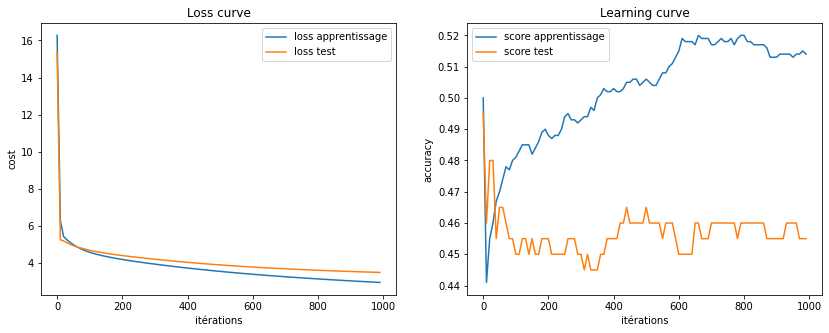

In [62]:
afficherApprentissage(cA2,ct2,sA2,st2)
A=W2

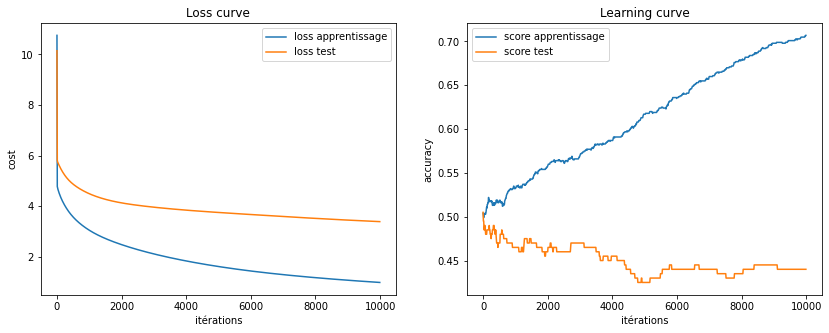

In [63]:
cA_test,ct_test,sA_test,st_test=[10.754326850983569, 4.774842078370078, 4.706834401706577, 4.6624424105507245, 4.619974454302656, 4.579373624464597, 4.5405103429367175, 4.503133340644747, 4.467395884395107, 4.433004417146094, 4.3998234326978425, 4.367980306534159, 4.337266635407241, 4.30744435640576, 4.278591371892172, 4.25070533586334, 4.223483215612166, 4.197042078791955, 4.171246703883508, 4.146034652766581, 4.1214535718966365, 4.097385023398155, 4.073816588464244, 4.050762855794224, 4.028131546084477, 4.005996903526087, 3.9842422479288118, 3.962951657969993, 3.942048508717072, 3.921534887161426, 3.901427460990553, 3.8816926771651836, 3.862329892318895, 3.8433265963247103, 3.8246939806940734, 3.8063917362362947, 3.788427742750225, 3.770785804048192, 3.753472976902433, 3.7364560740084563, 3.7197390720759063, 3.7033118696830845, 3.6871705646089885, 3.671300451087104, 3.6556977138284807, 3.640355225740404, 3.6252637458015955, 3.610418016443997, 3.5958105690029263, 3.58143537614359, 3.5672867563945405, 3.5533564118111123, 3.5396387459608447, 3.5261292904436545, 3.512819705710419, 3.4997039795513465, 3.4867775752376047, 3.474032519566109, 3.4614653024914603, 3.449068612584023, 3.4368383259242656, 3.4247688821250044, 3.412855059225339, 3.401092570304535, 3.3894762311401183, 3.3780032070492663, 3.3666684176460158, 3.3554670523379255, 3.344396852948749, 3.3334527857279244, 3.3226329463624498, 3.3119328528901733, 3.3013499920557203, 3.290881390636379, 3.2805242401024834, 3.2702758401606253, 3.260134260623253, 3.2500966209138027, 3.240161226862379, 3.2303260905130204, 3.2205892039692268, 3.2109489157341193, 3.201403835053032, 3.191952354365223, 3.182593226537333, 3.1733248769656375, 3.1641461453259594, 3.155055558762796, 3.1460523819163773, 3.137135376682071, 3.12830334460434, 3.1195549440605794, 3.110889382464322, 3.10230538569875, 3.0938019134599526, 3.085377747343573, 3.077032028996361, 3.0687634790305203, 3.0605711124163326, 3.05245367857343, 3.0444103144311705, 3.0364396715900184, 3.0285407281076115, 3.0207126387978316, 3.012954227490457, 3.005264254805549, 2.9976420059634203, 2.9900862909815697, 2.98259614080017, 2.975170530150169, 2.967808667848226, 2.9605094394423843, 2.9532719468446156, 2.9460952659267203, 2.938978526055026, 2.9319207723385334, 2.924921135354368, 2.9179787565355118, 2.911092761388397, 2.9042622017877595, 2.8974863379472535, 2.8907642633374517, 2.8840951873708236, 2.877478190860887, 2.8709124558207253, 2.864397219907004, 2.8579316188062913, 2.851514793231796, 2.8451460520351146, 2.8388245178337503, 2.8325494630956083, 2.8263200424393333, 2.8201355528554815, 2.8139951588162746, 2.807898205637149, 2.8018439309150955, 2.7958316472266262, 2.789860552363197, 2.7839300304852643, 2.778039396143896, 2.7721879668051623, 2.7663750997995074, 2.7606001468174846, 2.754862455727927, 2.7491614392303685, 2.7434964976798435, 2.737866998305461, 2.732272414057497, 2.726712137835508, 2.7211856261984817, 2.715692357353475, 2.710231758183831, 2.7048033274113523, 2.6994065509848935, 2.69404092103253, 2.688705942341218, 2.683401142168009, 2.67812603312015, 2.672880165990245, 2.6676630796226335, 2.662474316472594, 2.657313463707372, 2.652180065633629, 2.64707373029244, 2.641994028634969, 2.636940581605731, 2.6319129586817276, 2.626910809435776, 2.6219337345066234, 2.6169813754021822, 2.6120533708451252, 2.607149357596661, 2.6022690053354354, 2.597411969416007, 2.592577930598875, 2.5877665544430193, 2.582977528815836, 2.5782105464433043, 2.573465319825319, 2.568741534391874, 2.564038920315411, 2.5593571949700444, 2.5546960904224245, 2.5500553358991374, 2.5454346745109646, 2.540833853071745, 2.536252621566976, 2.5316907435830602, 2.5271479931669556, 2.522624124053231, 2.518118924938868, 2.5136321781137223, 2.5091636679915936, 2.5047131859687335, 2.5002805363356906, 2.4958655150364693, 2.491467941013404, 2.4870876157062685, 2.48272435602916, 2.4783779886808186, 2.4740483408966, 2.469735238394458, 2.4654385164478665, 2.4611580141272236, 2.456893572055029, 2.4526450320876756, 2.448412247756041, 2.444195068708208, 2.4399933531451405, 2.435806958497422, 2.43163574607923, 2.427479578905759, 2.423338329759786, 2.4192118668635287, 2.4151000642682057, 2.4110027977314292, 2.4069199481845507, 2.4028513933833837, 2.3987970197545745, 2.394756710628542, 2.3907303575082395, 2.3867178508214764, 2.38271908273784, 2.3787339476521874, 2.3747623420423127, 2.3708041668872553, 2.366859321432243, 2.36292770707246, 2.3590092298117784, 2.3551037973935487, 2.3512113133835886, 2.347331689819326, 2.343464837826947, 2.3396106676652426, 2.335769094929431, 2.331940035288553, 2.3281234040110412, 2.3243191204558573, 2.320527102755212, 2.3167472729296668, 2.31297955224331, 2.3092238626321766, 2.305480129175454, 2.301748276990983, 2.2980282323002994, 2.294319922788215, 2.29062327728154, 2.286938223820379, 2.283264693394709, 2.2796026170851493, 2.275951926585403, 2.272312556385363, 2.2686844382063565, 2.2650675081578937, 2.2614617002682342, 2.2578669522731962, 2.254283199366507, 2.2507103798903647, 2.2471484319820627, 2.2435972941436955, 2.240056906349101, 2.236527207874138, 2.233008139964316, 2.2294996436572947, 2.226001660298648, 2.2225141328383597, 2.2190370030243076, 2.2155702146123786, 2.2121137112212574, 2.208667437016881, 2.2052313359474556, 2.2018053534593083, 2.198389434594638, 2.1949835247091527, 2.191587570174434, 2.1882015170131726, 2.18482531216947, 2.1814589021506907, 2.178102234284937, 2.174755256238422, 2.1714179159556117, 2.168090161094142, 2.164771940278378, 2.1614632018463626, 2.1581638946432813, 2.1548739679166666, 2.1515933706860713, 2.1483220526918174, 2.1450599634359704, 2.141807053256787, 2.1385632720163184, 2.1353285703663123, 2.1321028987879576, 2.1288862084109805, 2.125678450150855, 2.1224795756581645, 2.1192895363028974, 2.116108284113858, 2.1129357712541434, 2.10977195010405, 2.106616773361761, 2.103470193930337, 2.1003321651473796, 2.097202640714619, 2.0940815743924923, 2.090968920275616, 2.0878646331276185, 2.0847686676367525, 2.081680979110507, 2.0786015230733312, 2.0755302555542277, 2.0724671328419517, 2.0694121115440702, 2.066365148973684, 2.063326202470007, 2.060295229989385, 2.057272189923132, 2.054257040982464, 2.0512497423658105, 2.0482502537705733, 2.0452585352579713, 2.042274547334628, 2.0392982510025033, 2.036329607796366, 2.033368579454532, 2.030415128496137, 2.027469217698284, 2.0245308104107917, 2.0215998703803346, 2.018676361893365, 2.0157602496656604, 2.012851498888807, 2.009950075164427, 2.007055944723621, 2.0041690740360503, 2.001289430225111, 1.9984169807749785, 1.9955516936621132, 1.9926935372466628, 1.989842480389537, 1.9869984923682233, 1.9841615429197463, 1.9813316021197271, 1.9785086405597168, 1.97569262925744, 1.9728835394935886, 1.9700813430606212, 1.967286012113504, 1.9644975191782805, 1.9617158371813457, 1.9589409393607409, 1.9561727993809612, 1.9534113911472413, 1.950656689020561, 1.9479086675987538, 1.9451673018496682, 1.942432567028856, 1.9397044386900588, 1.9369828926917911, 1.9342679051768337, 1.931559452509628, 1.928857511425175, 1.9261620587932675, 1.9234730718141246, 1.9207905278980866, 1.9181144046611134, 1.915444679954644, 1.9127813318675182, 1.9101243386469602, 1.9074736787712636, 1.9048293308844997, 1.9021912738248183, 1.8995594865641618, 1.8969339482899439, 1.8943146383332947, 1.8917015361410876, 1.8890946213324378, 1.8864938736592776, 1.883899273005569, 1.881310799378787, 1.8787284329122211, 1.8761521538179096, 1.8735819424660476, 1.871017779291757, 1.8684596448624993, 1.865907519803193, 1.8633613848508772, 1.8608212208423816, 1.8582870086661605, 1.8557587293027609, 1.8532363638150084, 1.8507198933299587, 1.8482092990645091, 1.845704562274584, 1.843205664294238, 1.8407125865454728, 1.8382253104719017, 1.835743817614863, 1.833268089542049, 1.8307981079068774, 1.8283338544093408, 1.825875310805079, 1.8234224589114554, 1.8209752805950536, 1.8185337577728107, 1.8160978724526704, 1.8136676066526545, 1.8112429424715624, 1.8088238620666173, 1.8064103476411784, 1.8040023814637596, 1.8015999458558702, 1.7992030232141467, 1.796811595978754, 1.7944256466565822, 1.7920451578127223, 1.7896701120953495, 1.7873004922016749, 1.7849362808974116, 1.78257746101666, 1.7802240154704325, 1.7778759272323468, 1.775533179355377, 1.7731957549655977, 1.7708636372680204, 1.7685368095358904, 1.766215255131193, 1.7638989574960784, 1.7615879001524681, 1.759282066707638, 1.756981440864083, 1.7546860063905474, 1.7523957471715457, 1.7501106471641696, 1.7478306904227603, 1.7455558610992286, 1.7432861434400917, 1.7410215217871328, 1.7387619805844405, 1.7365075043687022, 1.7342580777871393, 1.7320136855825246, 1.7297743126089937, 1.7275399438150243, 1.725310564262435, 1.7230861591199882, 1.7208667136640474, 1.7186522132796271, 1.7164426434602087, 1.7142379898132527, 1.7120382380560863, 1.7098433740161123, 1.707653383636789, 1.7054682529716425, 1.703287968193461, 1.701112515582994, 1.6989418815331183, 1.6967760525611169, 1.6946150152923904, 1.692458756464448, 1.690307262936852, 1.6881605216769462, 1.6860185197688842, 1.6838812444099238, 1.68174868291312, 1.6796208226994525, 1.6774976513107618, 1.6753791563938176, 1.6732653257083556, 1.6711561471243357, 1.6690516086221991, 1.6669516982897408, 1.664856404321677, 1.6627657150222308, 1.6606796187919255, 1.6585981041454751, 1.6565211596923466, 1.654448774144926, 1.6523809363143467, 1.6503176351054245, 1.648258859523805, 1.6462045986629128, 1.6441548417111629, 1.6421095779445858, 1.6400687967228986, 1.6380324874974774, 1.6360006397935505, 1.6339732432204903, 1.6319502874648675, 1.6299317622873133, 1.6279176575182952, 1.6259079630594089, 1.6239026688767337, 1.6219017649999714, 1.6199052415203319, 1.6179130885845774, 1.6159252963938358, 1.6139418551999716, 1.6119627553039426, 1.6099879870487275, 1.6080175408235269, 1.6060514070485792, 1.6040895761866443, 1.6021320387273377, 1.600178785190336, 1.5982298061211109, 1.5962850920838407, 1.5943446336671636, 1.5924084214706136, 1.590476446108574, 1.5885486982050188, 1.5866251683896695, 1.58470584729506, 1.5827907255585747, 1.5808797938087895, 1.5789730426763466, 1.577070462780538, 1.5751720447321618, 1.5732777791281543, 1.5713876565546099, 1.5695016675775366, 1.5676198027446657, 1.5657420525825796, 1.5638684075983862, 1.5619988582711564, 1.5601333950556484, 1.5582720083803359, 1.5564146886428916, 1.5545614262127954, 1.552712211427972, 1.5508670345953748, 1.5490258859887867, 1.5471887558479507, 1.545355634380799, 1.5435265117598345, 1.5417013781232467, 1.539880223573698, 1.5380630381812557, 1.5362498119789443, 1.5344405349676609, 1.5326351971115673, 1.5308337883422887, 1.5290362985565944, 1.5272427176193946, 1.5254530353629845, 1.5236672415866934, 1.5218853260591714, 1.5201072785188612, 1.518333088674537, 1.516562746205281, 1.514796240764296, 1.5130335619753792, 1.5112746994375221, 1.5095196427253623, 1.507768381388955, 1.5060209049556181, 1.504277202928909, 1.5025372647960635, 1.5008010800191123, 1.499068638046321, 1.4973399283044841, 1.4956149402058982, 1.4938936631478466, 1.4921760865112792, 1.4904621996658738, 1.488751991966462, 1.487045452758502, 1.4853425713767257, 1.4836433371462299, 1.4819477393830187, 1.4802557673961478, 1.4785674104886197, 1.4768826579565864, 1.4752014990921003, 1.473523923183825, 1.4718499195160624, 1.4701794773710248, 1.4685125860295563, 1.4668492347728743, 1.4651894128803218, 1.4635331096342898, 1.4618803143164882, 1.460231016211392, 1.4585852046082868, 1.4569428687979045, 1.455303998076261, 1.4536685817441581, 1.4520366091079235, 1.4504080694817314, 1.4487829521838558, 1.4471612465438808, 1.4455429418956056, 1.4439280275849136, 1.4423164929658518, 1.4407083274028567, 1.4391035202714388, 1.4375020609575304, 1.4359039388604282, 1.4343091433910544, 1.4327176639735588, 1.4311294900472462, 1.4295446110646395, 1.4279630164931776, 1.42638469581687, 1.424809638535613, 1.4232378341668717, 1.4216692722448183, 1.4201039423218407, 1.4185418339706108, 1.4169829367803777, 1.415427240363485, 1.4138747343512545, 1.412325408396679, 1.4107792521744005, 1.409236255381942, 1.407696407738967, 1.4061596989906628, 1.4046261189051885, 1.4030956572753952, 1.401568303920407, 1.4000440486849566, 1.3985228814408506, 1.3970047920872377, 1.395489770549818, 1.3939778067841573, 1.3924688907742857, 1.3909630125331018, 1.3894601621032643, 1.3879603295595695, 1.3864635050063299, 1.384969678579648, 1.383478840447319, 1.3819909808101518, 1.3805060899021966, 1.3790241579896205, 1.3775451753730439, 1.3760691323873493, 1.374596019401192, 1.3731258268196207, 1.371658545081875, 1.3701941646630398, 1.368732676074443, 1.3672740698632455, 1.3658183366140557, 1.3643654669481071, 1.3629154515233555, 1.3614682810353955, 1.3600239462174815, 1.3585824378416997, 1.3571437467164142, 1.3557078636897484, 1.3542747796478667, 1.352844485515539, 1.3514169722552398, 1.3499922308700494, 1.3485702524018288, 1.3471510279294434, 1.3457345485728456, 1.3443208054905136, 1.342909789880366, 1.3415014929790383, 1.3400959060632844, 1.3386930204480991, 1.337292827488116, 1.335895318577886, 1.3345004851495257, 1.3331083186754233, 1.3317188106663824, 1.3303319526726123, 1.3289477362834146, 1.3275661531254759, 1.3261871948652182, 1.3248108532073826, 1.323437119894169, 1.3220659867074274, 1.3206974454659894, 1.3193314880264941, 1.3179681062835003, 1.3166072921690406, 1.3152490376525974, 1.313893334739988, 1.3125401754749126, 1.3111895519369279, 1.3098414562416592, 1.3084958805421676, 1.30715281702661, 1.3058122579186753, 1.3044741954776413, 1.3031386219980914, 1.3018055298099258, 1.300474911276549, 1.2991467587968217, 1.2978210648033863, 1.2964978217625254, 1.2951770221738694, 1.2938586585713574, 1.292542723520878, 1.2912292096211355, 1.2899181095040086, 1.28860941583261, 1.2873031213025474, 1.2859992186404285, 1.284697700604334, 1.2833985599838051, 1.2821017895977325, 1.2808073822970878, 1.2795153309618064, 1.27822562850224, 1.2769382678570196, 1.2756532419957989, 1.2743705439155784, 1.273090166642643, 1.2718121032318708, 1.2705363467654816, 1.2692628903544647, 1.2679917271361927, 1.266722850275508, 1.26545625296484, 1.264191928422721, 1.2629298698936, 1.2616700706491053, 1.2604125239856043, 1.25915722322554, 1.2579041617167075, 1.2566533328317715, 1.2554047299677917, 1.25415834654687, 1.2529141760147968, 1.2516722118423922, 1.250432447522681, 1.2491948765731005, 1.2479594925347617, 1.246726288970402, 1.2454952594669149, 1.244266397632812, 1.2430396970991322, 1.2418151515195714, 1.240592754568935, 1.2393724999438398, 1.2381543813628524, 1.2369383925647317, 1.235724527310489, 1.2345127793806636, 1.2333031425777918, 1.2320956107236052, 1.2308901776606909, 1.2296868372516487, 1.2284855833785997, 1.2272864099435439, 1.2260893108680109, 1.2248942800931832, 1.2237013115787774, 1.2225103993034532, 1.2213215372657193, 1.2201347194816645, 1.2189499399863462, 1.2177671928329326, 1.2165864720937583, 1.2154077718579854, 1.2142310862333117, 1.2130564093458058, 1.2118837353380605, 1.2107130583713603, 1.209544372623437, 1.2083776722904576, 1.2072129515846328, 1.2060502047364268, 1.2048894259922158, 1.2037306096162979, 1.2025737498892695, 1.2014188411077777, 1.2002658775866093, 1.1991148536555991, 1.1979657636619745, 1.1968186019689255, 1.195673362955695, 1.1945300410186173, 1.1933886305689514, 1.1922491260350077, 1.1911115218604902, 1.1899758125053632, 1.1888419924451574, 1.1877100561719318, 1.1865799981924405, 1.185451813030092, 1.184325495223139, 1.1832010393263437, 1.182078439909508, 1.180957691558062, 1.1798387888727133, 1.1787217264700103, 1.1776064989822228, 1.176493101055933, 1.1753815273542034, 1.1742717725550644, 1.1731638313515678, 1.1720576984527242, 1.1709533685822262, 1.1698508364793616, 1.1687500968988958, 1.1676511446103277, 1.166553974399019, 1.1654585810648215, 1.164364959423668, 1.163273104306184, 1.1621830105583209, 1.1610946730412528, 1.160008086631739, 1.1589232462211858, 1.157840146716865, 1.1567587830408768, 1.1556791501305648, 1.1546012429388735, 1.15352505643387, 1.1524505855987075, 1.1513778254322748, 1.1503067709485122, 1.1492374171764155, 1.1481697591611413, 1.1471037919624505, 1.1460395106558072, 1.1449769103320733, 1.1439159860976111, 1.142856733074128, 1.141799146399003, 1.1407432212246145, 1.1396889527194436, 1.1386363360672003, 1.1375853664675393, 1.1365360391349462, 1.1354883493003385, 1.1344422922100894, 1.1333978631258128, 1.1323550573254302, 1.1313138701022514, 1.1302742967653492, 1.1292363326397048, 1.1281999730662642, 1.1271652134012724, 1.1261320490177091, 1.1251004753036395, 1.1240704876634968, 1.1230420815177098, 1.122015252302399, 1.120989995470226, 1.1199663064893384, 1.1189441808443894, 1.1179236140358604, 1.1169046015807522, 1.1158871390116427, 1.1148712218779966, 1.113856845745017, 1.1128440061945795, 1.1118326988244163, 1.110822919248558, 1.1098146630978991, 1.1088079260195332, 1.107802703676464, 1.1067989917486807, 1.1057967859324362, 1.1047960819401428, 1.1037968755013183, 1.1027991623615883, 1.1018029382833294, 1.100808199045011, 1.0998149404425521, 1.0988231582876031, 1.0978328484090507, 1.0968440066522487, 1.0958566288789497, 1.0948707109680786, 1.0938862488149736, 1.0929032383317445, 1.091921675447258, 1.0909415561070852, 1.0899628762738818, 1.0889856319265305, 1.0880098190612872, 1.087035433690608, 1.0860624718444583, 1.0850909295692195, 1.0841208029281584, 1.0831520880012178, 1.082184780885925, 1.0812188776957146, 1.0802543745615472, 1.0792912676310409, 1.0783295530686838, 1.0773692270559168, 1.0764102857908946, 1.075452725488915, 1.0744965423820145, 1.073541732719108, 1.0725882927659691, 1.0716362188053636, 1.0706855071367696, 1.069736154076535, 1.0687881559581913, 1.0678415091316305, 1.0668962099638635, 1.0659522548387703, 1.0650096401567448, 1.0640683623354688, 1.063128417808874, 1.062189803028119, 1.0612525144607048, 1.0603165485913104, 1.0593819019209236, 1.0584485709674605, 1.0575165522654906, 1.0565858423662084, 1.05565643783733, 1.0547283352632721, 1.053801531245099, 1.0528760224003142, 1.0519518053628394, 1.051028876783445, 1.050107233328815, 1.0491868716825818, 1.0482677885444294, 1.0473499806304836, 1.0464334446731431, 1.0455181774211841, 1.0446041756395699, 1.0436914361093674, 1.0427799556278181, 1.0418697310084168, 1.040960759080544, 1.0400530366896397, 1.0391465606971126, 1.0382413279803842, 1.0373373354325979, 1.0364345799627013, 1.0355330584955869, 1.034632767971706, 1.0337337053470297, 1.0328358675934333, 1.0319392516981483, 1.0310438546638274, 1.0301496735087465, 1.0292567052662671, 1.0283649469851848, 1.0274743957295338, 1.0265850485784724, 1.0256969026262135, 1.0248099549820877, 1.0239242027701345, 1.0230396431296702, 1.0221562732145733, 1.0212740901933202, 1.020393091249282, 1.019513273580441, 1.0186346343989858, 1.017757170931815, 1.0168808804200697, 1.016005760119203, 1.0151318072988045, 1.0142590192425138, 1.0133873932481237, 1.0125169266272123, 1.0116476167053357, 1.0107794608216194, 1.0099124563290365, 1.009046600594111, 1.0081818909967433, 1.0073183249303226, 1.0064558998015745, 1.0055946130301836, 1.0047344620492822, 1.003875444304803, 1.0030175572556754, 1.0021607983735858, 1.0013051651429963, 1.0004506550609642, 0.999597265637065, 0.9987449943933111, 0.9978938388639533, 0.9970437965955674, 0.996194865146803, 0.9953470420882364, 0.9945003250023949, 0.9936547114836705, 0.9928101991379488, 0.9919667855828462, 0.991124468447434, 0.9902832453720898, 0.9894431140083586, 0.988604072019238, 0.9877661170782979, 0.986929246870476, 0.9860934590910797, 0.9852587514465146, 0.9844251216534676, 0.9835925674392861, 0.982761086541551, 0.9819306767080832, 0.9811013356968683, 0.9802730612759816, 0.9794458512232798, 0.9786197033264246] ,[10.145816970122656, 5.811673802593751, 5.746914813511564, 5.715277674367654, 5.685750900121986, 5.657268115165837, 5.628898487573934, 5.601433493640341, 5.574337467945509, 5.548240356448782, 5.52298936710609, 5.497950073262839, 5.4734256533764, 5.449709263472746, 5.426457796245805, 5.403737314570683, 5.381549985659319, 5.359951803566046, 5.338830681739446, 5.3182968970419005, 5.29818650562197, 5.278574357090504, 5.259376274014787, 5.240638911152388, 5.2223656506337015, 5.204413764944735, 5.1870320860693155, 5.169943775067359, 5.153269894197528, 5.137001658030735, 5.12097879934928, 5.105486810357038, 5.090221581624387, 5.075471088116094, 5.060924102744942, 5.046720949429297, 5.032852381180986, 5.019308436719282, 5.00607816890103, 4.993151842302209, 4.980519173725769, 4.9680180568027925, 4.9559412159990766, 4.943980017177246, 4.932275473019522, 4.920956281593447, 4.909731241689998, 4.8987334293365965, 4.887953677940124, 4.877258188776956, 4.866891519862258, 4.856717381031335, 4.846614489110095, 4.836696497323699, 4.826955692433762, 4.817384737213756, 4.807976605886423, 4.798633957039753, 4.789535517880237, 4.780497806836083, 4.771605386826341, 4.762777791856962, 4.754091565080604, 4.7455406220741905, 4.737119512999716, 4.728763654554847, 4.720533936079333, 4.712425435601, 4.704383372872253, 4.6964121685656925, 4.688559438586176, 4.680820076572898, 4.673151089866179, 4.665555005030486, 4.658034717255241, 4.650623452822966, 4.643287283601044, 4.636027281727151, 4.628845143225305, 4.621741293184238, 4.6147162483400335, 4.60774955323561, 4.6008648995658135, 4.594061673289508, 4.587339645612231, 4.580666382345313, 4.5740771411284395, 4.567556948350411, 4.561107417543896, 4.55472923393362, 4.548412466337846, 4.5421598329084745, 4.535983078435607, 4.529872172683754, 4.523829439957259, 4.517847317532345, 4.511928010245771, 4.506072804307569, 4.500283400685969, 4.494553917460138, 4.488886151308333, 4.483281013043883, 4.477734611344322, 4.472243575427858, 4.466813381573411, 4.461437300974288, 4.456120283634578, 4.4508561893081175, 4.445649942428234, 4.440492538093487, 4.435388879586482, 4.430337708239351, 4.4253374851908385, 4.420386313719696, 4.415484950222025, 4.410631259733925, 4.405825709835951, 4.401066956565702, 4.396355005648229, 4.391688739405508, 4.387067164793049, 4.382488516121099, 4.377954920121854, 4.373463163537212, 4.369015058537079, 4.36460885882362, 4.360242373311117, 4.355917559524248, 4.35163398009312, 4.34738826351389, 4.343183431401623, 4.339016391190653, 4.334887912340337, 4.330797642164016, 4.326744642350581, 4.322729141540323, 4.3187501856155, 4.314807033193205, 4.310899876034065, 4.307029119677185, 4.3031924220535815, 4.29939114695469, 4.295625212827338, 4.291892943258628, 4.288193832054516, 4.284528402671937, 4.280896547959794, 4.277297801698248, 4.273731443893992, 4.270197490937983, 4.266696573459824, 4.263225879848519, 4.259787319733079, 4.256379523064277, 4.253002014256081, 4.249655594009368, 4.2463399581264865, 4.243053495598719, 4.2397970963596965, 4.236569040004223, 4.233370339680152, 4.230200638680064, 4.227059550051857, 4.223946792856662, 4.220861941448138, 4.217803259286693, 4.214773282431691, 4.211770151857029, 4.208792093374362, 4.205841719749917, 4.202917201244344, 4.200018198114054, 4.197145882074592, 4.194296878622147, 4.1914739270094366, 4.188675135049904, 4.185900176607025, 4.1831503229467595, 4.180423642598582, 4.177719831328834, 4.175040165718436, 4.172382713422295, 4.169748793083624, 4.16713645956874, 4.164545394147723, 4.16197695412054, 4.15942915654508, 4.156903403126323, 4.154397683105735, 4.151913412942023, 4.149450297648441, 4.147006344799092, 4.144581259559864, 4.1421764628540245, 4.139791702622199, 4.137424948065569, 4.1350776601031365, 4.132747823623792, 4.130438701253471, 4.128144693626399, 4.12587088626849, 4.123613438069632, 4.121372085551608, 4.119148360122945, 4.116942020024842, 4.11475282200984, 4.112578690085162, 4.110421201739717, 4.108280116382708, 4.10615336180205, 4.10404252990014, 4.101947393254137, 4.099865866835866, 4.097801438174442, 4.095750161448936, 4.093711801247586, 4.091688005582582, 4.089680440960427, 4.0876832562548575, 4.0857018727054255, 4.083732324052504, 4.081776282673145, 4.079833550034236, 4.077903922862935, 4.075985304428111, 4.074079397671382, 4.072186008367965, 4.07030494842421, 4.068434123360966, 4.066575253915217, 4.064728158028879, 4.062892655785862, 4.061066657921051, 4.059251903486533, 4.057450129924773, 4.055655432820573, 4.05387338260583, 4.052099988702625, 4.050338917859518, 4.048586180232588, 4.046841621543325, 4.04510891515175, 4.043384081921337, 4.041670801454437, 4.039965095831217, 4.038266824451311, 4.03657967084747, 4.034901581152565, 4.0332305072787955, 4.031568227144158, 4.029914607363167, 4.028267610995598, 4.0266309227910115, 4.025000607150303, 4.023378445193829, 4.021764315246067, 4.0201580986825185, 4.018557783969419, 4.016967043250886, 4.015381981617871, 4.013804380349355, 4.012234131782272, 4.010671127271687, 4.009113389141762, 4.007562694963412, 4.006020812023292, 4.004482040563214, 4.00295188570908, 4.001428386875235, 3.999909598934356, 3.998399140988314, 3.9968932239249466, 3.9953936149029006, 3.993898393437526, 3.9924111550920136, 3.9909281517127027, 3.9894529657614783, 3.9879818702809327, 3.9865166197023383, 3.9850553324232583, 3.9836015629612604, 3.9821516290075203, 3.9807090696209286, 3.979270226023102, 3.9778368362538403, 3.976407060439171, 3.9749844044647165, 3.973565258186305, 3.972153109495465, 3.970744373861423, 3.9693407688563505, 3.967940498182502, 3.9665470122757562, 3.9651567780220867, 3.9637732265881898, 3.962392850905742, 3.9610173437602634, 3.9596449548210173, 3.958279072850975, 3.956916244888891, 3.955559838291917, 3.954206427523819, 3.9528576777221462, 3.951511882932938, 3.9501723661236094, 3.948835755619181, 3.9475053514652947, 3.9461778102888876, 3.9448547659523228, 3.9435361921041885, 3.9422204351718095, 3.9409107340155107, 3.939603815127355, 3.9383012838595888, 3.937003117569027, 3.9357092949544823, 3.934418205810532, 3.933133013286225, 3.9318505272231983, 3.930572316187284, 3.9292983600188314, 3.9280286405092495, 3.9267615908748064, 3.9255002932636365, 3.9242416428261016, 3.9229871677399992, 3.9217368500068193, 3.9204906710222907, 3.9192471078732054, 3.918007661793584, 3.916773805547209, 3.9155425322822555, 3.9143153212030017, 3.9130906847221367, 3.911871550593381, 3.9106549683261838, 3.909442389136751, 3.9082337937307994, 3.907029162620454, 3.9058270507080137, 3.9046302990174775, 3.903436040801295, 3.902245683716373, 3.9010592066380516, 3.8998751986274285, 3.898696428507244, 3.8975200993628993, 3.896347581893991, 3.8951788544120407, 3.8940138945852016, 3.892851332672153, 3.891693849789516, 3.8905387339592483, 3.8893873107636567, 3.888239556438664, 3.887094135269266, 3.885952350579149, 3.884815477329711, 3.883680886635716, 3.8825485754418185, 3.88142109591062, 3.880295860552326, 3.8791741289733173, 3.878055876235328, 3.8769410775364475, 3.875829706847716, 3.8747205024884854, 3.873614689713824, 3.872512241525734, 3.871413132465897, 3.8703161280083784, 3.869222424505941, 3.8681319949216424, 3.867044813563258, 3.8659608542555133, 3.8648789162135233, 3.8638001614264827, 3.8627245628428706, 3.8616520939137415, 3.8605827287261527, 3.859515301044202, 3.8584509381808174, 3.8573896132075074, 3.856330181112737, 3.855274861444319, 3.854221395384064, 3.853170876906936, 3.852123280376296, 3.851077493178002, 3.850034589428588, 3.848994544587898, 3.8479573330316055, 3.8469218682539403, 3.8458902546091145, 3.8448603510369974, 3.8438331947460482, 3.8428077254491697, 3.8417849671320097, 3.8407648954157594, 3.839747487237111, 3.8387327186068188, 3.837719562412581, 3.8367090117727094, 3.8357010440000807, 3.8346956357766975, 3.833691785740719, 3.832690463074964, 3.8316916455359955, 3.8306943505611573, 3.8297004846825975, 3.8287081106041536, 3.8277172245312774, 3.8267296983023757, 3.825743630522402, 3.8247599437179867, 3.8237786186562257, 3.8227987206915883, 3.8218211554003254, 3.8208459036542615, 3.819872946421209, 3.8189013730650685, 3.817932067355441, 3.8169650105200135, 3.816000184431964, 3.815036702199494, 3.8140754253576383, 3.813116336439926, 3.8121585653484154, 3.811202958240043, 3.81024949768625, 3.8092981663189263, 3.8083481171613682, 3.807400175055499, 3.8064543227168075, 3.805510544460076, 3.8045680147360965, 3.8036275371193042, 3.802688297479038, 3.8017518820850604, 3.800816683686841, 3.799883485435332, 3.7989514931662938, 3.7980214811259105, 3.7970934332058737, 3.7961673355931613, 3.7952424140525887, 3.7943194230803003, 3.793398347638663, 3.7924784291248264, 3.7915604075519083, 3.7906442675045584, 3.7897299952916272, 3.7888168514394476, 3.787905557274456, 3.7869960970387, 3.786087747597735, 3.785181214165803, 3.7842764824052484, 3.783372842750962, 3.782470986073413, 3.7815708991808505, 3.78067188469259, 3.7797753002209737, 3.77887909515763, 3.7779852924509076, 3.7770925334069694, 3.776201479269797, 3.775312116145411, 3.7744237768483186, 3.773537109942489, 3.77265210116076, 3.771768096031962, 3.770885730164755, 3.7700049893697587, 3.7691252319111435, 3.7682470797452594, 3.7673705195549476, 3.7664955366961634, 3.7656215058620344, 3.7647490330199997, 3.763877499722921, 3.7630075040344266, 3.762139031703076, 3.7612714759206813, 3.760406011389643, 3.759540858779881, 3.758677768300663, 3.7578155607118697, 3.7569548060528586, 3.7560949200582274, 3.7552370319898434, 3.754379428891919, 3.753523793969706, 3.7526689918951512, 3.7518155704762894, 3.750962967287386, 3.750112266560792, 3.7492618202973977, 3.7484132475550758, 3.747565454844241, 3.746718967908905, 3.7458732449724184, 3.7450288054689977, 3.744185634463592, 3.7433431988325343, 3.7425020088136973, 3.7416620489010666, 3.7408227963872456, 3.7399847501830745, 3.7391478961776934, 3.7383117200989635, 3.7374767119536023, 3.7366428566343517, 3.7358096504996205, 3.734977572842435, 3.7341461265921225, 3.7333157851897383, 3.732486533127746, 3.731657882282617, 3.7308302968970306, 3.7300037621286535, 3.7291777979588585, 3.7283528596721953, 3.727528932265825, 3.726705545063136, 3.725882691526765, 3.725061265846621, 3.7242403490123417, 3.723419935548209, 3.7226009015369192, 3.721781907627832, 3.72096426299531, 3.720147078615119, 3.7193307781094176, 3.718514919062228, 3.717699919888524, 3.716885343322323, 3.7160716020078444, 3.715258682669729, 3.7144461551265278, 3.713634424611583, 3.7128234775767295, 3.712012891586862, 3.7112030658779793, 3.710393582911607, 3.709584836286209, 3.7087764147501425, 3.7079687059369495, 3.707161696731592, 3.706354983166883, 3.7055489461992064, 3.704743187217665, 3.7039380821848953, 3.703133237335756, 3.702329403274007, 3.7015254319554107, 3.7007220714866005, 3.6999193082614, 3.699116760782282, 3.6983147904421703, 3.697513384049433, 3.69671216668115, 3.6959111331328978, 3.6951106358687626, 3.6943106625959845, 3.693510847765666, 3.692711537340808, 3.691912371183006, 3.691113690773487, 3.6903151405328787, 3.6895170578185517, 3.6887194320344743, 3.6879219137458246, 3.6871244989879997, 3.686327517482618, 3.6855306259052885, 3.6847341524197392, 3.6839380861536153, 3.683142091288738, 3.682346488429991, 3.6815509459774614, 3.68075546044464, 3.679960348088081, 3.6791655999801676, 3.6783708928642787, 3.6775765371798936, 3.6767822128621117, 3.6759879186014075, 3.675193960140342, 3.6744003292715095, 3.67360671532412, 3.6728131162920885, 3.6720198318332344, 3.6712268545805613, 3.6704338823940557, 3.669640913246858, 3.6688482403570806, 3.6680555667784844, 3.6672631815260472, 3.6664707911648247, 3.665678682298607, 3.664886565602584, 3.664094724303077, 3.66330287175428, 3.6625110097410745, 3.6617194169676646, 3.660928089179281, 3.660136473227791, 3.65934539518604, 3.6585540322027414, 3.6577632006242937, 3.656972087218623, 3.6561812328925694, 3.655390635020781, 3.654599763206525, 3.653809412320494, 3.653018792776322, 3.6522284305900645, 3.6514383239267434, 3.650648215794937, 3.649858108526804, 3.6490682588151153, 3.648278414601457, 3.647488828812436, 3.646699252564549, 3.6459096895150522, 3.6451203897300206, 3.6443311083106598, 3.643541848909141, 3.6427528579801582, 3.641964135473156, 3.6411752043180696, 3.6403865477721684, 3.6395981667715147, 3.638809826609639, 3.6380215326797067, 3.637233289360056, 3.6364453333086453, 3.6356576645997096, 3.634869828582271, 3.6340822888517583, 3.6332950449772965, 3.6325076516385058, 3.631720785581909, 3.630933781258144, 3.6301470873706583, 3.6293604875367094, 3.628574204092945, 3.6277878067792644, 3.6270019512429945, 3.62621599247546, 3.6254303664456553, 3.624644863607815, 3.623859699943459, 3.6230746692436617, 3.622289776014269, 3.621505234875122, 3.6207208414827177, 3.6199366017234254, 3.6191525226344794, 3.618368810957849, 3.6175852692774346, 3.616802103208845, 3.616019116228182, 3.6152363157520107, 3.6144537063678897, 3.613671490296607, 3.6128894753210536, 3.6121078612472743, 3.6113262664804604, 3.6105450826555376, 3.609764312498139, 3.6089835806355115, 3.6082032727975744, 3.607423390876936, 3.6066435664189966, 3.605864178490417, 3.605085045896426, 3.6043061742143947, 3.6035277518419493, 3.6027495997390155, 3.601971725515134, 3.6011943127327974, 3.600417186218397, 3.5996403523125515, 3.5988638167952502, 3.5980877600648933, 3.5973118373973922, 3.596536576310267, 3.5957614599668895, 3.59498683920321, 3.594212547464571, 3.593438589965273, 3.5926649715859753, 3.5918918656453696, 3.591119109193571, 3.5903468714049995, 3.5895748277368003, 3.588803312018255, 3.5880321652375473, 3.5872613927442605, 3.5864911593284927, 3.585721148890268, 3.5849516869818365, 3.5841827763441882, 3.583414104224447, 3.582645991269532, 3.5818782857914027, 3.5811109907197802, 3.5803441118311095, 3.5795778076116735, 3.578811928223721, 3.5780464774219194, 3.577281459860671, 3.5765170316425605, 3.5757530451004875, 3.5749893560085115, 3.574226415402867, 3.573463781073536, 3.5727017535858225, 3.571940042905572, 3.571179090234098, 3.570418463993758, 3.569658313973105, 3.5688987865731763, 3.5681397422463763, 3.567381184991628, 3.5666231187642303, 3.565865548616245, 3.5651086167942694, 3.5643521862311447, 3.563596263027982, 3.56284084902474, 3.5620859496831976, 3.5613317020809676, 3.5605779754861677, 3.559824773060082, 3.5590720986955886, 3.5583199552199667, 3.5575683473452466, 3.5568174074874985, 3.5560670101982472, 3.5553171568981976, 3.5545678502649776, 3.5538190958105087, 3.553071023860557, 3.552323381565352, 3.551576426145754, 3.5508300351794646, 3.5500842092974074, 3.5493389546235012, 3.5485943942716465, 3.5478502871483255, 3.5471068808926636, 3.5463640553810296, 3.5456218132444897, 3.544880157578258, 3.5441390909629984, 3.543398617215552, 3.5426588574223183, 3.5419196940572037, 3.541181012280224, 3.540443050868122, 3.539705693789025, 3.5389690598353885, 3.5382329196443534, 3.5374973925769373, 3.5367625937397738, 3.53602829802897, 3.5352947343270746, 3.53456179187713, 3.5338294718830117, 3.5330977779703403, 3.532366712655329, 3.5316363866865914, 3.5309065830019946, 3.5301775222612326, 3.529448989584306, 3.528721202719506, 3.527994055342621, 3.5272675496280375, 3.526541688194853, 3.525816471788504, 3.525091903218938, 3.524368087425092, 3.523644818927812, 3.5229222033948817, 3.522200344835295, 3.5214791413704947, 3.5207584950723936, 3.5200386079433783, 3.5193193827637357, 3.5186008190827693, 3.517882919141, 3.517165684744008, 3.5164491170742544, 3.5157332168473885, 3.5150180840167766, 3.514303525689613, 3.5135896386062786, 3.512876520826822, 3.5121639829683073, 3.511452216523127, 3.5107410320019143, 3.510030620753105, 3.5093208879856297, 3.508611837020459, 3.5079033739880687, 3.507195686290213, 3.506488683923907, 3.505782365839709, 3.5050767341860958, 3.5043717880702503, 3.5036675308436793, 3.502963963029214, 3.502261084095144, 3.5015588972146343, 3.5008574014214275, 3.5001566854568025, 3.4994565746738973, 3.4987571593234215, 3.4980584370735324, 3.4973604979661266, 3.4966631690181647, 3.4959665359594005, 3.4952706024683167, 3.494575450668686, 3.4938809138987112, 3.4931870763989044, 3.492494023913003, 3.491801588898498, 3.4911098543401806, 3.4904188222110815, 3.489728574915621, 3.489038946802835, 3.488350023887762, 3.487661887637515, 3.4869743726508706, 3.4862875623713143, 3.485601458640508, 3.484916060367191, 3.48423144710465, 3.4835474604672254, 3.4828641817021446, 3.4821816098653837, 3.4814997453196583, 3.4808185880486997, 3.480138140354721, 3.4794583989358943, 3.4787793678530483, 3.478101043772069, 3.4774234306133427, 3.4767465251980236, 3.4760703295048674, 3.4753947677268138, 3.474719991169645, 3.4740459236753987, 3.4733724939246176, 3.4726998475499835, 3.4720279112476704, 3.4713566109941065, 3.4706860238015826, 3.4700162166759014, 3.4693470510643665, 3.4686785940800293, 3.4680108499743767, 3.4673438857484804, 3.466677562251106, 3.466011948720941, 3.4653469777439274, 3.4646827856255324, 3.4640193066509894, 3.4633565371462476, 3.4626944089943255, 3.4620330601449463, 3.461372356099058, 3.4607124271496916, 3.4600531446500664, 3.459394570582382, 3.458736707525643, 3.4580795535884294, 3.457423111580103, 3.4567673797961658, 3.4561123565097582, 3.455457977143221, 3.4548043746474124, 3.4541514155115682, 3.4534992317359996, 3.452847692605784, 3.4521968611090155, 3.4515467402371827, 3.4508973277809263, 3.450248624734595, 3.449600566770897, 3.448953277463947, 3.448306636919779, 3.447660765889627, 3.4470155410799475, 3.4463710225029125, 3.4457272112122515, 3.4450841074854948, 3.4444417122712903, 3.4437999610052636, 3.4431589776355485, 3.4425186403304844, 3.441879007405139, 3.4412401414036107, 3.440601862834546, 3.439964347644872, 3.4393275373904486, 3.4386914329762055, 3.438055974506733, 3.4374212189941455, 3.4367871696964625, 3.436153824800475, 3.4355211801153316, 3.434889241644133, 3.4342580050618365, 3.4336274151844988, 3.4329975268744786, 3.432368341027048, 3.431739858797028, 3.431112075643647, 3.4304849953349925, 3.4298585613026513, 3.4292328843616553, 3.428607850883351, 3.427983519323988, 3.427359888072488, 3.4267369017098233, 3.426114669122842, 3.425493081187123, 3.4248721930929698, 3.424252005557765, 3.42363251438631, 3.4230137207275755, 3.4223955736664955, 3.42177817605408, 3.421161424846854, 3.420545370869123, 3.4199300124085075, 3.4193152995618914, 3.4187013330576215, 3.4180880124883912, 3.4174753872097257, 3.416863458443835, 3.4162522246697256, 3.4156416346976766, 3.4150317398634944, 3.414422588166483, 3.413814032641177, 3.413206220208118, 3.4125990997049485, 3.41199262405528, 3.411386843789064, 3.4107817542576595, 3.410177357016818, 3.409573650586869, 3.408970592062794, 3.408368221534146, 3.407766543739898, 3.4071655573694524, 3.40656521387118, 3.4059656056602687, 3.405366644265159, 3.4047683715484185, 3.404170789405082, 3.40357384727662, 3.402977596333215, 3.402382035055347, 3.4017871620394615, 3.4011929790354807, 3.4005994363562806, 3.400006626075109, 3.3994144600461937, 3.398822934212053, 3.3982321428747566, 3.397641992423165, 3.397052529325033, 3.3964637520965573, 3.395875659244591, 3.395288209397579, 3.394701488240021, 3.39411540760499, 3.3935299698807104, 3.392945259983044, 3.392361190539516, 3.3917778067679287, 3.3911951071168587, 3.3906130866949056, 3.3900317093527237, 3.389451015923221, 3.3888710048648547, 3.38829167508733, 3.3877129871591842, 3.3871349816165424, 3.3865576570372027, 3.3859810118772957, 3.385405048516623, 3.3848297213407093], [0.504, 0.502, 0.499, 0.503, 0.503, 0.503, 0.504, 0.503, 0.503, 0.505, 0.508, 0.511, 0.51, 0.514, 0.514, 0.516, 0.516, 0.522, 0.519, 0.519, 0.518, 0.517, 0.518, 0.518, 0.518, 0.518, 0.517, 0.518, 0.515, 0.513, 0.513, 0.513, 0.514, 0.516, 0.515, 0.513, 0.514, 0.516, 0.515, 0.515, 0.517, 0.519, 0.518, 0.517, 0.519, 0.518, 0.516, 0.516, 0.516, 0.517, 0.518, 0.518, 0.519, 0.518, 0.516, 0.517, 0.517, 0.516, 0.517, 0.516, 0.512, 0.512, 0.514, 0.515, 0.513, 0.514, 0.514, 0.518, 0.519, 0.52, 0.521, 0.521, 0.524, 0.525, 0.526, 0.527, 0.527, 0.529, 0.529, 0.529, 0.53, 0.53, 0.531, 0.531, 0.531, 0.532, 0.532, 0.531, 0.531, 0.531, 0.531, 0.532, 0.532, 0.532, 0.534, 0.535, 0.533, 0.533, 0.532, 0.532, 0.533, 0.533, 0.533, 0.535, 0.535, 0.535, 0.535, 0.535, 0.534, 0.536, 0.534, 0.534, 0.534, 0.533, 0.533, 0.533, 0.534, 0.535, 0.534, 0.533, 0.533, 0.535, 0.536, 0.537, 0.537, 0.537, 0.537, 0.537, 0.536, 0.537, 0.536, 0.536, 0.537, 0.537, 0.538, 0.539, 0.539, 0.539, 0.54, 0.54, 0.541, 0.541, 0.541, 0.541, 0.542, 0.543, 0.542, 0.542, 0.543, 0.543, 0.543, 0.543, 0.543, 0.543, 0.544, 0.544, 0.546, 0.547, 0.548, 0.548, 0.549, 0.549, 0.551, 0.551, 0.551, 0.55, 0.55, 0.55, 0.55, 0.549, 0.552, 0.552, 0.552, 0.553, 0.553, 0.553, 0.554, 0.554, 0.554, 0.554, 0.554, 0.555, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.554, 0.555, 0.555, 0.555, 0.556, 0.556, 0.557, 0.557, 0.558, 0.559, 0.56, 0.56, 0.56, 0.56, 0.56, 0.561, 0.562, 0.562, 0.562, 0.562, 0.563, 0.563, 0.563, 0.563, 0.563, 0.563, 0.564, 0.564, 0.565, 0.564, 0.564, 0.562, 0.563, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.564, 0.565, 0.564, 0.565, 0.565, 0.564, 0.564, 0.564, 0.563, 0.563, 0.563, 0.563, 0.564, 0.564, 0.564, 0.564, 0.564, 0.563, 0.562, 0.561, 0.561, 0.563, 0.563, 0.564, 0.564, 0.564, 0.564, 0.564, 0.563, 0.563, 0.563, 0.564, 0.566, 0.566, 0.566, 0.567, 0.566, 0.566, 0.566, 0.567, 0.567, 0.567, 0.568, 0.569, 0.567, 0.566, 0.566, 0.565, 0.565, 0.565, 0.565, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.566, 0.567, 0.568, 0.568, 0.569, 0.57, 0.571, 0.572, 0.572, 0.572, 0.572, 0.573, 0.573, 0.573, 0.574, 0.574, 0.574, 0.574, 0.575, 0.575, 0.575, 0.575, 0.576, 0.576, 0.576, 0.577, 0.577, 0.576, 0.577, 0.577, 0.577, 0.577, 0.577, 0.577, 0.577, 0.577, 0.577, 0.577, 0.577, 0.576, 0.577, 0.578, 0.578, 0.579, 0.579, 0.578, 0.578, 0.579, 0.58, 0.58, 0.581, 0.582, 0.583, 0.582, 0.582, 0.582, 0.582, 0.582, 0.583, 0.583, 0.583, 0.583, 0.582, 0.582, 0.582, 0.582, 0.583, 0.583, 0.583, 0.583, 0.583, 0.583, 0.582, 0.582, 0.582, 0.583, 0.584, 0.583, 0.583, 0.583, 0.583, 0.583, 0.583, 0.583, 0.584, 0.584, 0.584, 0.585, 0.585, 0.585, 0.586, 0.586, 0.586, 0.587, 0.587, 0.587, 0.587, 0.587, 0.586, 0.587, 0.587, 0.587, 0.587, 0.587, 0.587, 0.587, 0.587, 0.588, 0.59, 0.591, 0.591, 0.59, 0.59, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.591, 0.592, 0.592, 0.592, 0.592, 0.594, 0.594, 0.595, 0.596, 0.596, 0.596, 0.596, 0.597, 0.597, 0.597, 0.597, 0.597, 0.597, 0.598, 0.597, 0.597, 0.597, 0.598, 0.598, 0.598, 0.598, 0.599, 0.599, 0.6, 0.6, 0.601, 0.601, 0.602, 0.602, 0.603, 0.603, 0.603, 0.602, 0.601, 0.602, 0.603, 0.603, 0.603, 0.604, 0.604, 0.604, 0.606, 0.606, 0.606, 0.608, 0.608, 0.608, 0.608, 0.608, 0.609, 0.609, 0.61, 0.61, 0.61, 0.61, 0.611, 0.612, 0.613, 0.613, 0.613, 0.613, 0.613, 0.613, 0.615, 0.616, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.619, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.619, 0.619, 0.618, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.62, 0.621, 0.621, 0.621, 0.622, 0.622, 0.623, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.625, 0.625, 0.625, 0.625, 0.625, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.623, 0.625, 0.626, 0.626, 0.627, 0.628, 0.627, 0.629, 0.63, 0.631, 0.631, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.633, 0.633, 0.634, 0.634, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.635, 0.636, 0.636, 0.636, 0.636, 0.636, 0.637, 0.637, 0.637, 0.637, 0.637, 0.638, 0.638, 0.638, 0.638, 0.638, 0.639, 0.639, 0.64, 0.64, 0.64, 0.641, 0.641, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.641, 0.641, 0.641, 0.641, 0.641, 0.641, 0.641, 0.642, 0.644, 0.645, 0.645, 0.645, 0.646, 0.646, 0.646, 0.646, 0.647, 0.648, 0.649, 0.649, 0.649, 0.649, 0.65, 0.65, 0.651, 0.651, 0.651, 0.651, 0.652, 0.652, 0.652, 0.653, 0.653, 0.653, 0.653, 0.653, 0.653, 0.654, 0.654, 0.655, 0.655, 0.655, 0.655, 0.654, 0.654, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.656, 0.656, 0.657, 0.657, 0.658, 0.658, 0.657, 0.657, 0.657, 0.657, 0.657, 0.659, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.661, 0.661, 0.661, 0.661, 0.661, 0.661, 0.662, 0.663, 0.663, 0.664, 0.664, 0.664, 0.664, 0.665, 0.665, 0.665, 0.665, 0.665, 0.664, 0.664, 0.665, 0.665, 0.665, 0.665, 0.665, 0.665, 0.665, 0.665, 0.665, 0.666, 0.666, 0.666, 0.666, 0.666, 0.666, 0.667, 0.667, 0.667, 0.668, 0.668, 0.668, 0.669, 0.669, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.671, 0.671, 0.671, 0.671, 0.671, 0.671, 0.671, 0.672, 0.672, 0.672, 0.672, 0.672, 0.672, 0.673, 0.674, 0.676, 0.676, 0.676, 0.676, 0.676, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.677, 0.678, 0.678, 0.679, 0.679, 0.679, 0.678, 0.678, 0.678, 0.679, 0.679, 0.679, 0.679, 0.68, 0.679, 0.679, 0.679, 0.679, 0.679, 0.68, 0.68, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682, 0.682, 0.683, 0.683, 0.683, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.684, 0.685, 0.685, 0.685, 0.685, 0.686, 0.686, 0.687, 0.686, 0.687, 0.687, 0.686, 0.687, 0.687, 0.687, 0.687, 0.687, 0.688, 0.688, 0.689, 0.689, 0.689, 0.689, 0.689, 0.689, 0.69, 0.69, 0.691, 0.692, 0.692, 0.692, 0.693, 0.693, 0.692, 0.692, 0.692, 0.692, 0.692, 0.692, 0.692, 0.692, 0.692, 0.693, 0.693, 0.693, 0.693, 0.693, 0.693, 0.694, 0.695, 0.695, 0.696, 0.696, 0.696, 0.696, 0.696, 0.696, 0.696, 0.697, 0.696, 0.697, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.698, 0.699, 0.699, 0.699, 0.699, 0.699, 0.699, 0.7, 0.7, 0.7, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.701, 0.702, 0.702, 0.702, 0.703, 0.703, 0.703, 0.702, 0.702, 0.702, 0.703, 0.703, 0.703, 0.703, 0.703, 0.703, 0.703, 0.703, 0.704, 0.704, 0.705, 0.705, 0.705, 0.705, 0.705, 0.705, 0.705, 0.705, 0.705, 0.705, 0.705, 0.705, 0.706, 0.706, 0.707, 0.707] ,[0.505, 0.495, 0.495, 0.485, 0.485, 0.49, 0.49, 0.485, 0.48, 0.48, 0.48, 0.48, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.49, 0.485, 0.485, 0.48, 0.48, 0.48, 0.475, 0.48, 0.48, 0.48, 0.485, 0.485, 0.485, 0.49, 0.49, 0.49, 0.485, 0.485, 0.48, 0.48, 0.485, 0.48, 0.475, 0.47, 0.47, 0.47, 0.47, 0.465, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.48, 0.48, 0.48, 0.48, 0.48, 0.485, 0.48, 0.48, 0.48, 0.48, 0.48, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.465, 0.465, 0.465, 0.465, 0.46, 0.46, 0.46, 0.465, 0.47, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.475, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.475, 0.475, 0.475, 0.475, 0.475, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.455, 0.455, 0.455, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.47, 0.47, 0.47, 0.465, 0.465, 0.465, 0.465, 0.465, 0.46, 0.46, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.465, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.455, 0.455, 0.455, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.445, 0.445, 0.445, 0.445, 0.445, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.43, 0.43, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.435, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.445, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44]
afficherApprentissage(cA_test,ct_test,sA_test,st_test)

# A l'aide d'un PMC : L couches dont L-1 cachées

$$\text{On notera } n^{[l]} \text{ le nombre de caractéristiques de la couche l} \\
\text{On considèrera que X est l'activation de la couche 0}\\
A^{[l]} \text{ l'activation à la couche l}\\
W^{[l]} \text{ les poids de la couche l}
$$

### Forward propagation

#### Rappel des shapes: On connait les shapes de la couche 0 et de la couche L

$$\begin{alignat}{5}
\underbrace{A^{[0]}}_{(n^{[0]},m)} &= Xa\\
\underbrace{A^{[L]}}_{(n^{[L]}=1,m)} &\Rightarrow Log\_loss(A^{[L]})\\
\end{alignat}$$

#### Pour les autres couches

$$
\forall l \in \{1,...,L-1\} : couches\\
$$ 

$$\begin{alignat}{5}
&\underbrace{W^{[l]}}_{(n^{[l]},n^{[l-1]})}= initParam(n^{[l-1]},n^{[l]})\\
&\underbrace{B^{[l]}}_{(n^{[l]},1)}\\
&\underbrace{Z^{[l]}}_{(n^{[l]},m)}= \underbrace{W^{[l]}}_{(n^{[l]},n^{[l-1]})}.\underbrace{A^{[l-1]}}_{(n^{[l-1]},m)} + \underbrace{B^{[l]}}_{(n^{[l]},1)}\\
&\underbrace{A^{[l]}}_{(n^{[l]},m)} =  \frac{1}{1+e^{-Z^{[l]}}}\\
\end{alignat}$$

In [64]:
def initParam1(X,couches=[16,8,4]):
    '''Retourne un dictionnaire ou les clé sont le numéro des couches 
    et W,b les poids correspondants à celle-ci'''
    n=len(couches)
    les_W=dict()
    if n>0:
        les_W[1]=initParam(X.shape[0],couches[0])
    else:
        les_W[1]=initParam(X.shape[0],1)
    for i in range(2,n+1):
        les_W[i]=initParam(couches[i-2],couches[i-1])
    
    if n>0:
        les_W[n+1]= initParam(couches[n-1],1)   
    return les_W

def forwardPropagation(X,les_poids):
    '''Retourne un dictionnaire ou les clé sont le numéro des couches 
    et A les activations correspondants à celle-ci'''
    L=len(les_poids)
    les_A= { 0 : X}
    for i in range(1,L+1):
        W,b=les_poids[i]
        Z=W.dot(les_A[i-1])+b
        A=1/ (1+np.exp(-Z))
        les_A[i]=A
    return les_A

def predict1(X,les_poids):
    A=forwardPropagation(X,les_poids)[len(les_poids)]
    return np.where(A>0.5,1.,0.) 
    
           
les_poids=initParam1(Xa)
print("Poids")   
for (w,b) in les_poids.values():
    print(w.shape,b.shape)
print("Activations")   
les_A=forwardPropagation(Xa,les_poids)
for a in les_A.values():
    if a.shape[0]!=Xa.shape[0]: #On affiche pas l'activation 0 qui est Xa
        print(a.shape)

Poids
(16, 4096) (16, 1)
(8, 16) (8, 1)
(4, 8) (4, 1)
(1, 4) (1, 1)
Activations
(16, 1000)
(8, 1000)
(4, 1000)
(1, 1000)


### Backward propagation

#### Pour la dernier couche :

$$
\begin{alignat}{5}
&\underbrace{\frac{\partial L}{\partial W^{[L]}}}_{(1,n^{[L-1]})} &= &\boxed{\frac{\partial L}{\partial A^{[L]}} . \frac{\partial A^{[L]}}{\partial Z^{[L]}}}.\frac{\partial Z^{[L]}}{\partial W^{[L]}} &= &\frac{\partial L}{\partial Z^{[L]}}.\frac{\partial Z^{[L]}}{\partial W^{[L]}}  \\
&\underbrace{\frac{\partial L}{\partial B^{[L]}}}_{(1,1)} &= &\boxed{\frac{\partial L}{\partial A^{[l]}} . \frac{\partial A^{[L]}}{\partial Z^{[L]}}}.\frac{\partial Z^{[L]}}{\partial B^{[L]}} &= &\frac{\partial L}{\partial Z^{[L]}}.\frac{\partial Z^{[L]}}{\partial B^{[L]}}\\
\end{alignat}$$


#### Pour toutes les couches :

$$
\begin{alignat}{5}
&\underbrace{\frac{\partial L}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})} &= &\frac{\partial L}{\partial Z^{[L]}}.(\frac{\partial Z^{[L]}}{\partial A^{[L-1]}}.\frac{\partial A^{[L-1]}}{\partial Z^{[L-1]}}...\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}.\frac{\partial A^{[l]}}{\partial Z^{[l]}}).\frac{\partial Z^{[l]}}{\partial W^{[l]}}  \\
&\underbrace{\frac{\partial L}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})} &= &\frac{\partial L}{\partial Z^{[l]}} .\frac{\partial Z^{[l]}}{\partial W^{[l]}}\\
&\underbrace{\frac{\partial L}{\partial B^{[l]}}}_{(n^{[l]},1)} &=  &\frac{\partial L}{\partial Z^{[l]}}.1 \\
\end{alignat}$$


#### Calculs des dérivées :

$$\begin{alignat}{5}
&\underbrace{\frac{\partial L}{\partial Z^{[L]}}}_{(1,m)} &= & \frac{1}{m}.\sum_{k=1}^m (a^{[L]}_{k}-y_k) \\
&\frac{\partial Z^{[l]}}{\partial W^{[l]}} &= & A^{[l-1]}\\
&\underbrace{\frac{\partial L}{\partial W^{[L]}}}_{(1,n^{[L-1]})} &=& \frac{1}{m}.\sum_{k=1}^m (a^{[L]}_{k}-y_k) . A^{[L-1]} =\frac{1}{m} \underbrace{(A^{[L]}-y)}_{(1,m)}.\underbrace{A^{[L-1]}{}^T}_{(m,n^{[L-1]})}&
\\
&\underbrace{\frac{\partial L}{\partial Z^{[l]}}}_{(n^{[l]},m)} &=& \frac{\partial L}{\partial Z^{[L]}}.\frac{\partial Z^{[L]}}{\partial Z^{[l]}} =\frac{\partial L}{\partial Z^{[l+1]}}.\color{red}{\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}}.\color{blue}{\frac{\partial A^{[l]}}{\partial Z^{[l]}}}= \underbrace{\frac{\partial L}{\partial Z^{[l+1]}}}_{(n^{[l+1]},m)}. \underbrace{\color{red}{W^{[l+1]}}}_{(n^{[l+1]},n^{[l]})}*\underbrace{\color{blue}{ A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}\\
& &=& \underbrace{W^{[l+1]}{}^T}_{(n^{[l]},n^{[l+1]})}.\underbrace{\frac{\partial L}{\partial Z^{[l+1]}}}_{(n^{[l+1]},m)}. \underbrace{A^{[l]}*(1- A^{[l]})}_{(n^{[l]},m)}\\
\newline
&\underbrace{\frac{\partial L}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})} &=& \boxed{\frac{1}{m} \underbrace{W^{[l+1]}{}^T}_{(n^{[l]},n^{[l+1]})}.\underbrace{\frac{\partial L}{\partial Z^{[l+1]}}}_{(n^{[l+1]},m)}*\underbrace{A^{[l]}*(1-A^{[l]})}_{(n^{[l]},m)}.\underbrace{A^{[l-1]}{}^T}_{(m,n^{[l-1]})}}\\
&\underbrace{\frac{\partial L}{\partial B^{[l]}}}_{(n^{[l]},1)} &=& \boxed{\frac{1}{m} \sum_{k=1}^m \underbrace{\frac{\partial L}{\partial Z^{[l]}}}_{(n^{[l]},m)} \quad\text{par ligne (axe=1)}}
\end{alignat}$$ 

In [65]:
def backwardPropagation(X,y,les_poids,les_activations):
    '''Retourne un dictionnaire ou les clé sont le numéro des couches 
    et dZ,Dw,db les gradients correspondants à celle-ci'''
    L=len(les_poids)
    m=X.shape[1]
    les_dZ= { L : 1/m * (les_activations[L]-y)}
    dW_L= 1/m * (les_activations[L]-y).dot(les_activations[L-1].T)
    dB_L= 1/m * np.sum(les_dZ[L],axis=1,keepdims=True)
    les_dWb= { L : (dW_L,dB_L)}
    for l in range(L-1,0,-1):
        W,b=les_poids[l+1]
        A=les_activations[l]
        dZ1=les_dZ[l+1]
        dZ= 1/m * (W.T).dot(dZ1)*A*(1-A)
        les_dZ[l]=dZ
        dW_l=dZ.dot(les_activations[l-1].T)
        dB_l=np.sum(dZ,axis=1,keepdims=True)
        les_dWb[l]=(dW_l,dB_l)
    return les_dZ,les_dWb

def mAj(les_poids,les_dWb,alpha):
    for l in range(1,len(les_poids)+1):
        dw,db=les_dWb[l]
        W,b=les_poids[l]
        b=b-alpha*db
        W=W-alpha*dw
        les_poids[l]=(W,b)
        
def learn(Xa,couches=[16,8,4],alpha=0.1, iter=5000): 
    les_poids=initParam1(Xa,couches)
    k=0
    while k<iter:
        les_A=forwardPropagation(Xa,les_poids)
        _,les_dWb=backwardPropagation(Xa,ya,les_poids,les_A)
        mAj(les_poids,les_dWb,alpha)
        k+=1
    return les_poids     

        
def learn_affichage(Xa,Xt,ya,yt,couches=[16,8,4],alpha=0.1, iter=200,bid=1): 
    les_poids=initParam1(Xa,couches)
    k=0
    couts_A,couts_t,scores_A,scores_t=[],[],[],[]
    while k<iter:
        les_A=forwardPropagation(Xa,les_poids)
        _,les_dWb=backwardPropagation(Xa,ya,les_poids,les_A)
        mAj(les_poids,les_dWb,alpha)
        k+=1
        
        if k%bid==0: # pour diminuer le nombre de calculs
            couts_A.append(log_loss(les_A[len(les_poids)],ya))
            couts_t.append(log_loss(forwardPropagation(Xt,les_poids)[len(les_poids)],yt))
            scores_A.append(accuracy_score(ya[0],predict1(Xa,les_poids)[0]))
            scores_t.append(accuracy_score(yt[0],predict1(Xt,les_poids)[0]))
           
    return les_poids,couts_A,couts_t,scores_A,scores_t




### Testons sur un petit échantillon

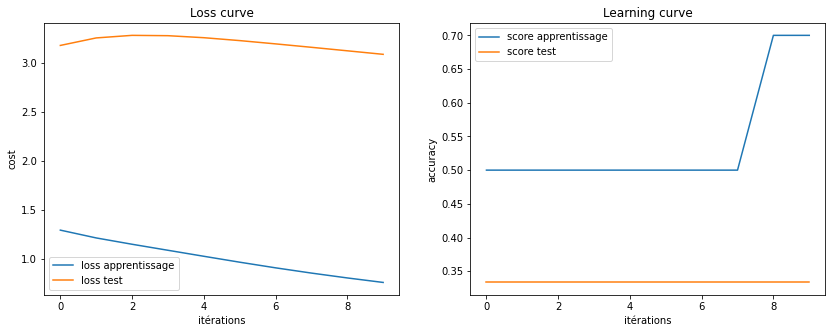

In [66]:
_,cA1,ct1,sA1,st1= learn_affichage(Xa[:,:10],Xt[:,:3],ya[:,:10],yt[:,:3],[1024,512,64],0.1,10)
afficherApprentissage(cA1,ct1,sA1,st1,1)

### Testons sur Xa

### Une couches cachée : 32

In [ ]:
les_poids,cA2,ct2,sA2,st2= learn_affichage(Xa,Xt,ya,yt,[32],0.1,1000,10)
afficherApprentissage(cA2,ct2,sA2,st2,10)

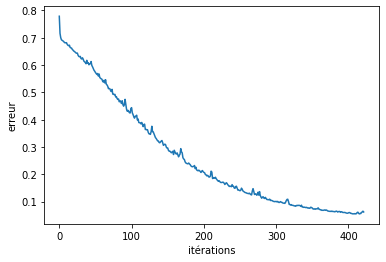

In [68]:
clf = MLPClassifier(max_iter=1000,activation='logistic',hidden_layer_sizes=(32,),alpha=0.01 ,random_state=0)
clf.fit(Xa.T, ya.T)
plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()

In [69]:
print(f'Xa score : {clf.score(Xa.T,ya.T)}')
print(f'Xt score : {clf.score(Xt.T,yt.T)}')

Xa score : 1.0
Xt score : 0.545


### Deux couches cachées : 10 , 10

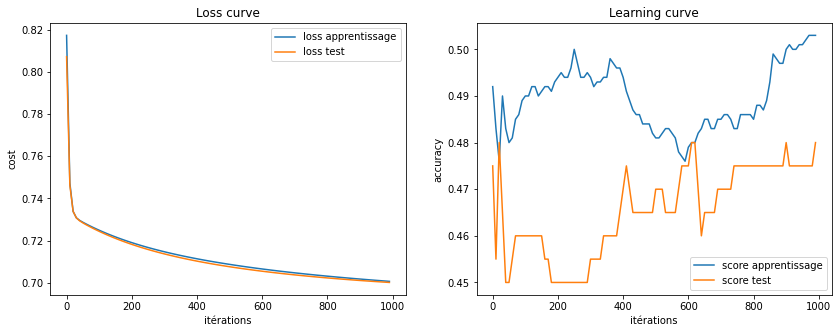

In [80]:
les_poids,cA2,ct2,sA2,st2= learn_affichage(Xa,Xt,ya,yt,[10,10],0.1,1000,10)
afficherApprentissage(cA2,ct2,sA2,st2,10)

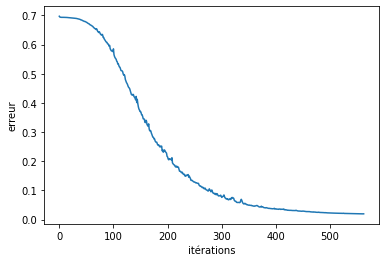

In [71]:
clf = MLPClassifier(max_iter=1000,activation='logistic',hidden_layer_sizes=(10,10),alpha=0.01 ,random_state=0)
clf.fit(Xa.T, ya.T)
plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()

In [72]:
print(f'Xa score : {clf.score(Xa.T,ya.T)}')
print(f'Xt score : {clf.score(Xt.T,yt.T)}')

Xa score : 1.0
Xt score : 0.57


### 0 couche cachée 

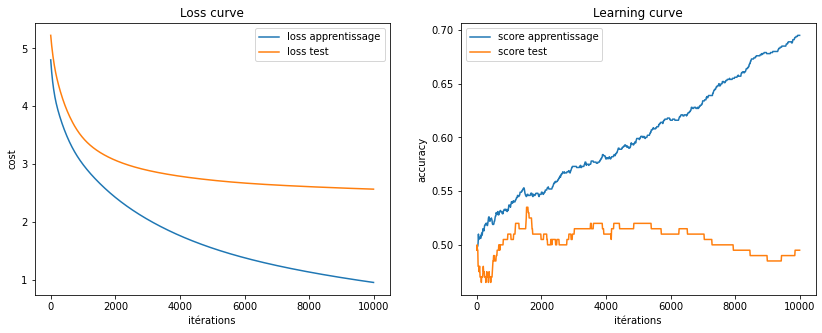

In [78]:
les_poids,cA2,ct2,sA2,st2= learn_affichage(Xa,Xt,ya,yt,[],0.01,1000,10)
afficherApprentissage(cA2,ct2,sA2,st2,10)

In [74]:
clf = MLPClassifier(max_iter=1000, random_state=0)

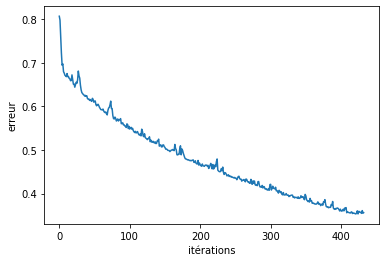

In [75]:
clf = MLPClassifier(max_iter=1000,activation='logistic',hidden_layer_sizes=(),alpha=0.01 ,random_state=0)
clf.fit(Xa.T, ya.T)
plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()

In [76]:
print(f'Xa score : {clf.score(Xa.T,ya.T)}')
print(f'Xt score : {clf.score(Xt.T,yt.T)}')

Xa score : 0.904
Xt score : 0.545
